## $Z^*$ known

### Training Steps

In [57]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from experiments import generate_data
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

def cossim(z, z_):
    return -F.cosine_similarity(z.T, z_.T).mean()

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy()))
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0)
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256, 1024]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i
    
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        MLP = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU()).to(device)
        logs_mlps[h].append(run_experiment(MLP, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "MLPs": avg_mlps
}

# New function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_training_steps.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

ImportError: cannot import name 'GatedSAE' from 'models' (/Users/charlesoneill/sparse-inference/experiments/models.py)

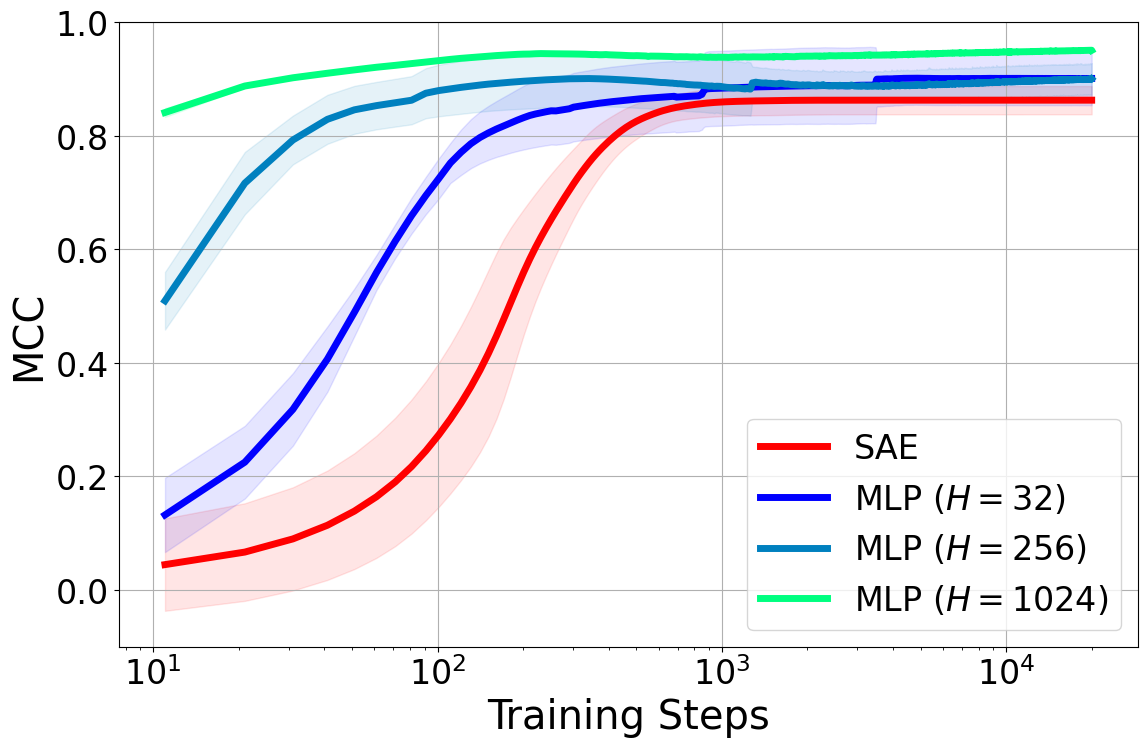

In [17]:
# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-', 
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1, 
                 avg_sae['mcc_test'] - avg_sae['mcc_test_std'], 
                 avg_sae['mcc_test'] + avg_sae['mcc_test_std'], 
                 alpha=alpha, color='red')

colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-', 
             color=color, label=f'MLP ($H={h}$)', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1, 
                     avg_mlp['mcc_test'] - avg_mlp['mcc_test_std'], 
                     avg_mlp['mcc_test'] + avg_mlp['mcc_test_std'], 
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_D_training_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

### FLOPs

In [14]:
def calculate_sae_inference_flops(M, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # Linear layer FLOPs
    linear_flops = (2 * M * N)  # includes matrix multiplication and bias addition
    
    # ReLU activation FLOPs
    relu_flops = N  # one comparison per output neuron
    
    # Total FLOPs for one sample
    flops_per_sample = linear_flops + relu_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_sae_training_flops(M, N, num_samples, num_steps, batch_size=None):
    """
    Calculate the number of FLOPs for training an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_sae_inference_flops(M, N, 1)
    
    # Backward pass FLOPs
    relu_grad_flops = N  # ReLU gradient
    linear_grad_flops = (2 * N * M) + N  # Linear layer gradient
    weight_update_flops = 2 * (M * N + N)  # Weight update
    
    backward_flops = relu_grad_flops + linear_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

# Example usage:
M, N = 8, 16
num_samples = 1024
num_steps = 20000

inference_flops = calculate_sae_inference_flops(M, N, num_samples)
training_flops = calculate_sae_training_flops(M, N, num_samples, num_steps)

print(f"Inference FLOPs: {inference_flops}")
print(f"Training FLOPs: {training_flops}")

Inference FLOPs: 278528
Training FLOPs: 17367040000


In [15]:
def calculate_mlp_inference_flops(M, h, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # First Linear layer FLOPs
    linear1_flops = 2 * M * h
    
    # First ReLU activation FLOPs
    relu1_flops = h
    
    # Second Linear layer FLOPs
    linear2_flops = 2 * h * N
    
    # Second ReLU activation FLOPs
    relu2_flops = N
    
    # Total FLOPs for one sample
    flops_per_sample = linear1_flops + relu1_flops + linear2_flops + relu2_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_mlp_training_flops(M, h, N, num_samples, num_steps, batch_size=None):
    """
    Calculate the number of FLOPs for training an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_mlp_inference_flops(M, h, N, 1)
    
    # Backward pass FLOPs
    relu2_grad_flops = N
    linear2_grad_flops = (2 * N * h) + N
    relu1_grad_flops = h
    linear1_grad_flops = (2 * M * h) + h
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * h + h + h * N + N)
    
    # Total backward pass FLOPs
    backward_flops = relu2_grad_flops + linear2_grad_flops + relu1_grad_flops + linear1_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_training_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    # Total FLOPs for testing (inference on test set)
    total_testing_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    
    # Grand total FLOPs
    grand_total_flops = total_training_flops + total_testing_flops
    
    return grand_total_flops

# Example usage:
M, N = 8, 16
hidden_layers = [32, 256, 1024]
num_samples = 1024
num_steps = 20000

for h in hidden_layers:
    inference_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    training_flops = calculate_mlp_training_flops(M, h, N, num_samples, num_steps)
    print(f"Hidden layer size: {h}")
    print(f"Inference FLOPs: {inference_flops}")
    print(f"Total Training + Testing FLOPs: {training_flops}")
    print()

Hidden layer size: 32
Inference FLOPs: 1622016
Total Training + Testing FLOPs: 99288662016

Hidden layer size: 256
Inference FLOPs: 12861440
Total Training + Testing FLOPs: 782840381440

Hidden layer size: 1024
Inference FLOPs: 51396608
Total Training + Testing FLOPs: 3126446276608



In [20]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, corr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def pairwise_corr(z, z_):
    return np.mean([corr(a, b)[0] for a, b in zip(z.T, z_.T)])

def cossim(z, z_):
    return -F.cosine_similarity(z.T, z_.T).mean()

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    criterion = cossim
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    # Calculate initial FLOPs
    if isinstance(model, nn.Sequential) and len(model) == 2:  # SAE
        total_flops = calculate_sae_training_flops(M, N, num_data, 0)  # 0 steps initially
    else:  # MLP
        h = model[0].out_features
        total_flops = calculate_mlp_training_flops(M, h, N, num_data, 0)  # 0 steps initially
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_ = model(X_train)
        loss = criterion(S_train, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(pairwise_corr(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_ = model(X_test)
                loss = criterion(S_test, S_)
            log['loss_test'].append(loss.item())
            log['mcc_test'].append(pairwise_corr(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            # Calculate and log total FLOPs up to this point
            if isinstance(model, nn.Sequential) and len(model) == 2:  # SAE
                total_flops = calculate_sae_training_flops(M, N, num_data, i+1)
            else:  # MLP
                h = model[0].out_features
                total_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1)
            log['flops'].append(total_flops)
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'flops': logs[0]['flops']  # FLOPs are deterministic, so we can just take the first run
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256, 1024]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i
    
    SAE = nn.Sequential(nn.Linear(M, N), nn.ReLU()).to(device)
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        MLP = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU()).to(device)
        logs_mlps[h].append(run_experiment(MLP, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_flops.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/fixed_Z_flops.json'.")

Running experiments: 100%|██████████| 5/5 [14:32<00:00, 174.55s/it]

Experiment completed. Results saved to 'results/fixed_Z_flops.json'.


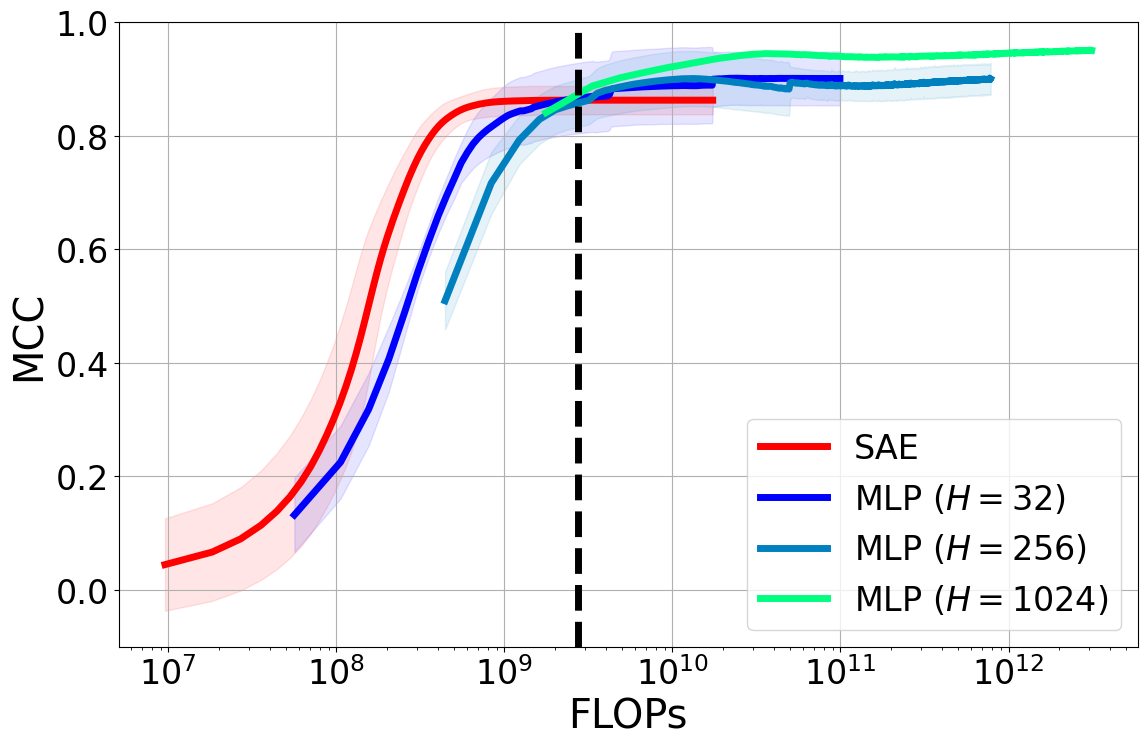

Average crossover point: 2.73e+09 FLOPs


In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_training_steps_and_flops.json', 'r') as f:
    data = json.load(f)

# Function to find crossover point
def find_crossover(sae_flops, sae_mcc, mlp_flops, mlp_mcc):
    for i in range(1, len(mlp_mcc)):
        if mlp_mcc[i-1] <= sae_mcc[-1] and mlp_mcc[i] > sae_mcc[-1]:
            return (mlp_flops[i-1] + mlp_flops[i]) / 2
    return None

# Calculate crossover points
sae_flops = np.array(data['SAE']['flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])

crossover_points = []
for h, mlp_data in data['MLPs'].items():
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    crossover = find_crossover(sae_flops, sae_mcc, mlp_flops, mlp_mcc)
    if crossover is not None:
        crossover_points.append(crossover)

average_crossover = np.mean(crossover_points) if crossover_points else None

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP ($H={h}$)', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)

# Plot average crossover line
if average_crossover:
    plt.axvline(x=average_crossover, color='black', linestyle='--', linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_flops.pdf', dpi=300, bbox_inches='tight')
plt.show()

if average_crossover:
    print(f"Average crossover point: {average_crossover:.2e} FLOPs")
else:
    print("No crossover points found")

## Fixed $D^*$

In [7]:
def calculate_sparse_coding_inference_flops(M, N, num_samples, learn_D=False):
    """
    Calculate the number of FLOPs for inference in SparseCoding.
    
    Args:
    M (int): Number of measurements
    N (int): Number of sparse sources
    num_samples (int): Number of samples to perform inference on
    learn_D (bool): Whether D is being learned or not
    
    Returns:
    int: Total number of FLOPs for inference
    """
    flops = 0
    
    if learn_D:
        # Normalization of D_
        flops += M * N * 2  # Norm calculation
        flops += M * N     # Division
    
    # Exponential of log_S_
    flops += N * num_samples
    
    # Matrix multiplication (S_ @ D_)
    flops += 2 * M * N * num_samples
    
    return flops

def calculate_sparse_coding_training_flops(M, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training SparseCoding.
    
    Args:
    M (int): Number of measurements
    N (int): Number of sparse sources
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether D is being learned or not
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (same as inference)
    forward_flops = calculate_sparse_coding_inference_flops(M, N, 1, learn_D)
    
    # Loss calculation
    loss_flops = M * batch_size * 2  # MSE
    loss_flops += N * batch_size     # L1
    
    # Backward pass FLOPs (approximation, actual might vary based on autograd)
    backward_flops = forward_flops * 2  # Roughly twice the forward pass
    
    # Parameter updates
    update_flops = N * batch_size
    if learn_D:
        update_flops += M * N
    
    # Total FLOPs for one training iteration
    flops_per_iteration = forward_flops + loss_flops + backward_flops + update_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

# Example usage
M, N = 8, 16
num_samples = 1024
train_flops = calculate_sparse_coding_training_flops(M, N, num_samples, 20000, learn_D=True)
print(f"Total FLOPs for training: {train_flops}")
inference_flops = calculate_sparse_coding_inference_flops(M, N, num_samples, learn_D=True)
print(f"Total FLOPs for inference: {inference_flops}")

def calculate_sae_training_flops(M, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether the decoder weights are being learned
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (including decoder)
    forward_flops = 2 * M * N + N + 2 * N * M  # Encoder + ReLU + Decoder
    if learn_D:
        forward_flops += M * N  # Normalization of D
    
    # Backward pass FLOPs
    relu_grad_flops = N  # ReLU gradient
    linear_grad_flops = (2 * N * M) + N  # Linear layer gradient
    decoder_grad_flops = 2 * N * M  # Decoder gradient
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * N + N)  # Encoder weight update
    if learn_D:
        weight_update_flops += 2 * N * M  # Decoder weight update
    
    backward_flops = relu_grad_flops + linear_grad_flops + decoder_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    return total_flops

def calculate_mlp_training_flops(M, h, N, num_samples, num_steps, learn_D=False, batch_size=None):
    """
    Calculate the number of FLOPs for training an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Total number of training samples
    num_steps (int): Number of training steps
    learn_D (bool): Whether the decoder weights are being learned
    batch_size (int, optional): Batch size for training. If None, full batch is assumed.
    
    Returns:
    int: Total number of FLOPs for training
    """
    if batch_size is None:
        batch_size = num_samples
    
    # Forward pass FLOPs (including decoder)
    forward_flops = 2 * M * h + h + 2 * h * N + N + 2 * N * M  # First layer + ReLU + Second layer + ReLU + Decoder
    if learn_D:
        forward_flops += M * N  # Normalization of D
    
    # Backward pass FLOPs
    relu2_grad_flops = N
    linear2_grad_flops = (2 * N * h) + N
    relu1_grad_flops = h
    linear1_grad_flops = (2 * M * h) + h
    decoder_grad_flops = 2 * N * M
    
    # Weight update FLOPs
    weight_update_flops = 2 * (M * h + h + h * N + N)  # Encoder weight update
    if learn_D:
        weight_update_flops += 2 * N * M  # Decoder weight update
    
    # Total backward pass FLOPs
    backward_flops = relu2_grad_flops + linear2_grad_flops + relu1_grad_flops + linear1_grad_flops + decoder_grad_flops + weight_update_flops
    
    # Total FLOPs for one training iteration (forward + backward)
    flops_per_iteration = forward_flops + backward_flops
    
    # Calculate effective number of iterations
    effective_iterations = num_steps * (batch_size / num_samples)
    
    # Total FLOPs for all training
    total_training_flops = int(flops_per_iteration * num_samples * effective_iterations)
    
    # Total FLOPs for testing (inference on test set)
    #total_testing_flops = calculate_mlp_inference_flops(M, h, N, num_samples)
    
    # Grand total FLOPs
    grand_total_flops = total_training_flops #+ total_testing_flops
    
    return grand_total_flops

def calculate_mlp_inference_flops(M, h, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an MLP.
    
    Args:
    M (int): Number of input features
    h (int): Number of neurons in the hidden layer
    N (int): Number of output features
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # First Linear layer FLOPs
    linear1_flops = 2 * M * h
    
    # First ReLU activation FLOPs
    relu1_flops = h
    
    # Second Linear layer FLOPs
    linear2_flops = 2 * h * N
    
    # Second ReLU activation FLOPs
    relu2_flops = N
    
    # Decoder (output) layer FLOPs
    decoder_flops = 2 * N * M
    
    # Total FLOPs for one sample
    flops_per_sample = linear1_flops + relu1_flops + linear2_flops + relu2_flops + decoder_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

def calculate_sae_inference_flops(M, N, num_samples):
    """
    Calculate the number of FLOPs for inference in an SAE.
    
    Args:
    M (int): Number of input features
    N (int): Number of output features (neurons in the hidden layer)
    num_samples (int): Number of samples to perform inference on
    
    Returns:
    int: Total number of FLOPs for inference
    """
    # Encoder Linear layer FLOPs
    encoder_flops = 2 * M * N  # includes matrix multiplication and bias addition
    
    # ReLU activation FLOPs
    relu_flops = N  # one comparison per output neuron
    
    # Decoder Linear layer FLOPs
    decoder_flops = 2 * N * M  # matrix multiplication for reconstruction
    
    # Total FLOPs for one sample
    flops_per_sample = encoder_flops + relu_flops + decoder_flops
    
    # Total FLOPs for all samples
    total_flops = flops_per_sample * num_samples
    
    return total_flops

Total FLOPs for training: 1049559040000
Total FLOPs for inference: 278912


In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SparseAutoEncoder(nn.Module):
    def __init__(self, M, N, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        if self.learn_D:
            # Assert that D is not None
            assert D is not None, "D must be provided if learn_D is True"
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        self.decoder = nn.Linear(N, M, bias=False)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class MLP(nn.Module):
    def __init__(self, M, N, h, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        if self.learn_D:
            # Assert that D is not None
            assert D is not None, "D must be provided if learn_D is True"
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU())
        self.decoder = nn.Linear(N, M)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T.clone(), requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D=False, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D.clone(), requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.05):
    recon_loss = F.mse_loss(X_, X)
    l1_loss = l1_weight * torch.mean(torch.abs(S_))
    return recon_loss + l1_loss

def train(model, X_train, S_train, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    # Calculate initial FLOPs
    if isinstance(model, SparseAutoEncoder):
        total_flops = calculate_sae_training_flops(M, N, num_data, 0, learn_D=model.learn_D)
    elif isinstance(model, MLP):
        h = model.encoder[0].out_features
        total_flops = calculate_mlp_training_flops(M, h, N, num_data, 0, learn_D=model.learn_D)
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            # Print every 1000 steps
            if i % 1000 == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}")
            
            # Calculate and log total FLOPs up to this point
            if isinstance(model, SparseAutoEncoder):
                training_flops = calculate_sae_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                inference_flops = calculate_sae_inference_flops(M, N, num_data)
                total_flops = training_flops + inference_flops
            elif isinstance(model, MLP):
                h = model.encoder[0].out_features
                training_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1, learn_D=model.learn_D)
                inference_flops = calculate_mlp_inference_flops(M, h, N, num_data)
                total_flops = training_flops + inference_flops
            log['flops'].append(total_flops)

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}") 
    
    return log

def run_sae_ito(model, X_test, S_test, lr=1e-3, num_step=10000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_test': [], 'loss_test': [], 'flops': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_test)
        loss = reconstruction_loss_with_l1(X_test, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step:
            log['step'].append(i)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}")
            
            # Calculate and log total FLOPs up to this point
            total_flops = calculate_sparse_coding_training_flops(M, N, X_test.shape[0], i+1, learn_D=model.learn_D)
            log['flops'].append(total_flops)

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}") 
    
    return log

def run_experiment(model, X_train, S_train, X_test, S_test, num_step=20000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    if isinstance(model, SparseCoding):
        log = run_sae_ito(model, X_test, S_test, num_step=num_step, log_step=log_step)
    else:
        log = train(model, X_train, S_train, X_test, S_test, num_step=num_step, log_step=log_step)
    return log

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'flops': logs[0]['flops']  # FLOPs are deterministic, so we can just take the first run
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 20000
log_step = 10
seed = 20240625

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)

# Run experiments
logs_sae = []
logs_mlps = {h: [] for h in hidden_layers}
logs_sae_ito = []

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i

    SAE = SparseAutoEncoder(M, N, D.to(device), learn_D=False, seed=run_seed)
    print(f"Running experiment {i+1}/{num_runs} with SAE")
    logs_sae.append(run_experiment(SAE, X_train, S_train, X_test, S_test, seed=run_seed))

    SAE_ITO = SparseCoding(X_test, D.to(device), learn_D=False, seed=run_seed)
    print(f"Running experiment {i+1}/{num_runs} with SAE_ITO")
    logs_sae_ito.append(run_experiment(SAE_ITO, X_train, S_train, X_test, S_test, seed=run_seed))
    
    for h in hidden_layers:
        print(f"Running experiment {i+1}/{num_runs} with MLP (H={h})")
        MLP_model = MLP(M, N, h, D.to(device), learn_D=False, seed=run_seed).to(device)
        logs_mlps[h].append(run_experiment(MLP_model, X_train, S_train, X_test, S_test, seed=run_seed))

# Average logs
avg_sae = average_logs(logs_sae)
avg_sae_ito = average_logs(logs_sae_ito)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "SAE_ITO": avg_sae_ito,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/fixed_Z_flops_reconstruction.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/fixed_Z_flops_reconstruction.json'.")

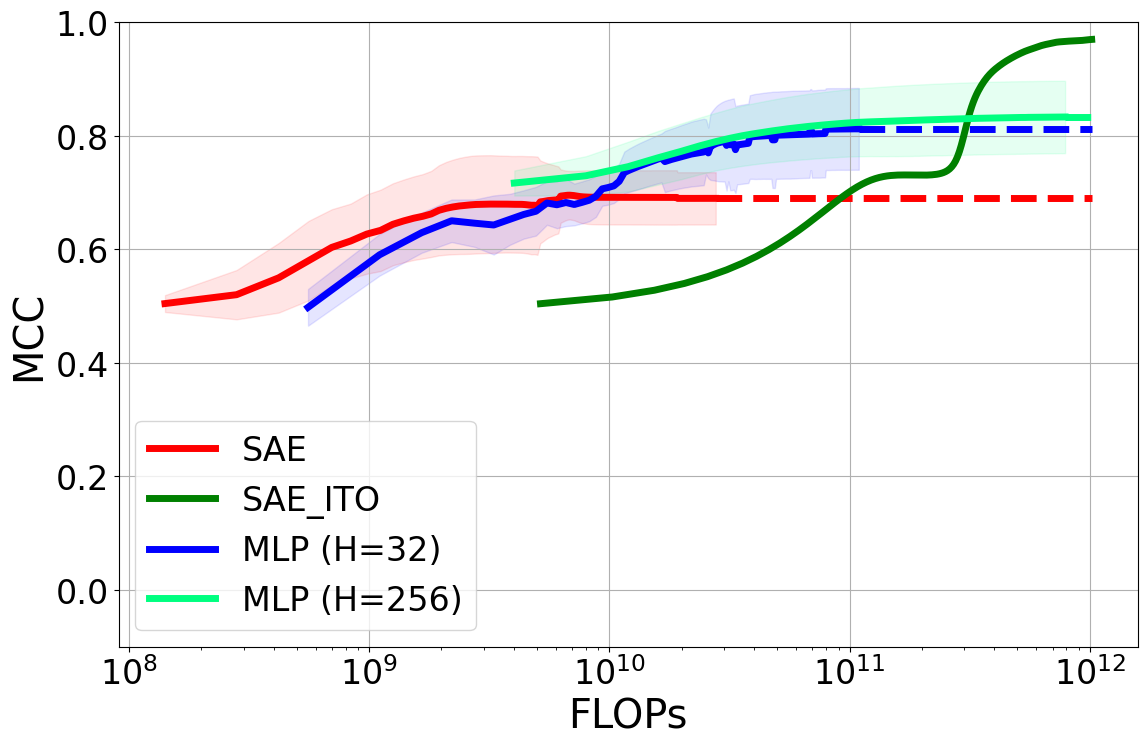

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['flops'][-1],
    data['SAE_ITO']['flops'][-1],
    max(data['MLPs'][h]['flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_mcc[-1], sae_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['flops'])
sae_ito_mcc = np.array(data['SAE_ITO']['mcc_test'])
sae_ito_mcc_std = np.array(data['SAE_ITO']['mcc_test_std'])

plt.plot(sae_ito_flops, sae_ito_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_mcc - sae_ito_mcc_std, sae_ito_mcc + sae_ito_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_mcc[-1], sae_ito_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_mcc[-1], mlp_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_flops_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

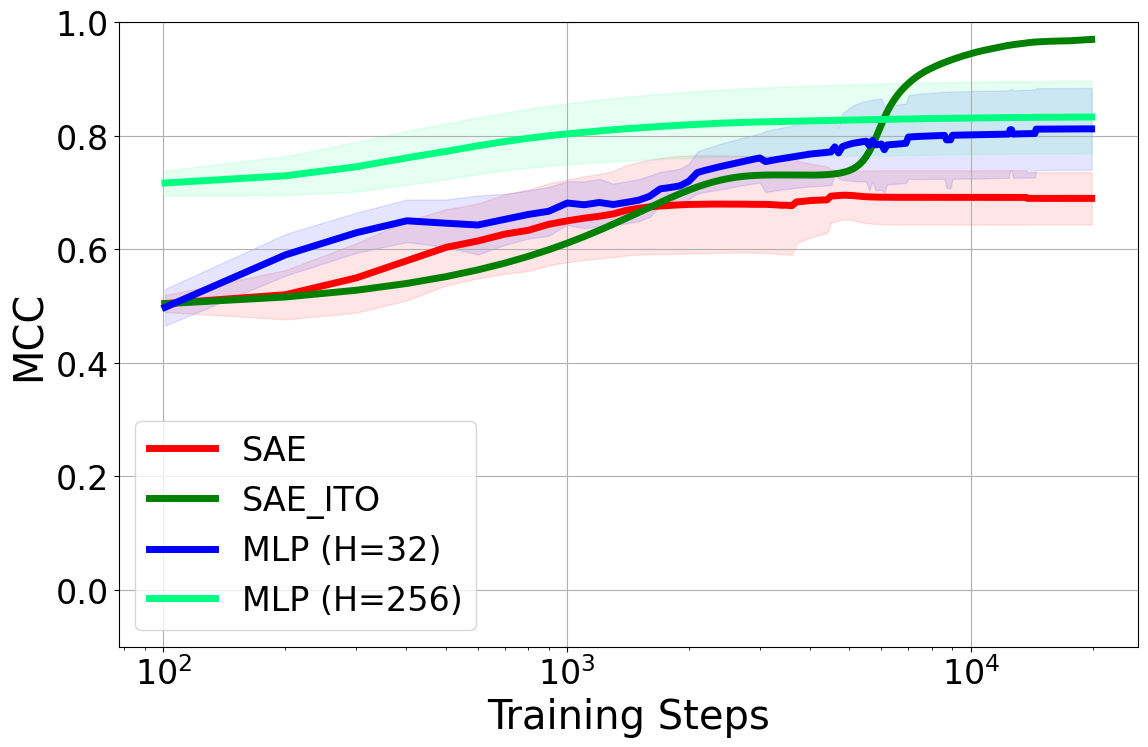

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/fixed_Z_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['mcc_test']) - np.array(avg_sae['mcc_test_std']),
                 np.array(avg_sae['mcc_test']) + np.array(avg_sae['mcc_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['mcc_test'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['mcc_test']) - np.array(avg_sae_ito['mcc_test_std']),
                 np.array(avg_sae_ito['mcc_test']) + np.array(avg_sae_ito['mcc_test_std']),
                 alpha=alpha, color='green')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['mcc_test']) - np.array(avg_mlp['mcc_test_std']),
                     np.array(avg_mlp['mcc_test']) + np.array(avg_mlp['mcc_test_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/fixed_Z_training_steps_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Unknown $Z^*$ and $D^*$

In [25]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import sys
sys.path.append('../')

from experiments import generate_data
from metrics import mcc, greedy_mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SparseAutoEncoder(nn.Module):
    def __init__(self, M, N, D, learn_D=True, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        self.decoder = nn.Linear(N, M, bias=False)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class MLP(nn.Module):
    def __init__(self, M, N, h, D, learn_D=True, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.encoder = nn.Sequential(nn.Linear(M, h), nn.ReLU(), nn.Linear(h, N), nn.ReLU())
        self.decoder = nn.Linear(N, M)
        if learn_D:
            self.decoder.weight = nn.Parameter(torch.randn(M, N), requires_grad=True)
        else:
            self.decoder.weight = nn.Parameter(D.T.clone(), requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = self.decoder(S_)
        return S_, X_

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D, seed=20240625):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        if learn_D:
            self.D = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D = nn.Parameter(data=D, requires_grad=False)
        self.log_S = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)

    def forward(self, X):
        if self.learn_D:
            self.D.data /= torch.linalg.norm(self.D.data, dim=0, keepdim=True)
        S = torch.exp(self.log_S)
        X_ = S @ self.D
        return S, X_

    def optimize_codes(self, X, num_iterations=1000, lr=1e-3):
        log_S_ = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)
        opt = torch.optim.Adam([log_S_], lr=lr)

        for j in range(num_iterations):
            S = torch.exp(log_S_)
            X_ = S @ self.D
            loss = reconstruction_loss_with_l1(X, X_, S)
            opt.zero_grad()
            loss.backward()
            opt.step()

        return torch.exp(log_S_.detach())

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.01):
    recon_loss = F.mse_loss(X_, X)
    l1_loss = l1_weight * torch.mean(torch.abs(S_))
    return recon_loss + l1_loss

def calculate_dict_mcc(D_true, D_learned):
    return greedy_mcc(D_true.T.cpu().numpy(), D_learned.T.cpu().numpy())

def calculate_optimize_codes_flops(M, N, num_data, num_iterations):
    # Initialization FLOPs
    init_flops = M * N + N

    # FLOPs per iteration
    flops_per_iteration = 4 * M * N + 2 * M + 11 * N

    # Total FLOPs
    total_flops = init_flops + (flops_per_iteration * num_iterations)

    # Multiply by num_data as this is done for each data point
    return total_flops * num_data

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            # Optimize codes for test set
            #with torch.no_grad():
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ model.D
            loss_test = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            log['loss_test'].append(loss_test.item())
            log['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC
            dict_mcc = calculate_dict_mcc(D_true, model.D.data)
            log['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs
            train_flops = calculate_sparse_coding_training_flops(M, N, X_train.shape[0], i+1, learn_D=model.learn_D)
            #test_flops = calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False)  # We're not learning D during testing
            test_flops = calculate_optimize_codes_flops(M, N, X_test.shape[0], 10_000)
            log['train_flops'].append(train_flops)
            log['test_flops'].append(test_flops)

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}, Dict MCC = {dict_mcc:.4f}")

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
    return log, model.D.data

def train(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log['step'].append(i)
            log['loss_train'].append(loss.item())
            log['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log['loss_test'].append(loss_test)
            log['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC
            if isinstance(model, SparseAutoEncoder) or isinstance(model, MLP):
                D_learned = model.decoder.weight.data.T
            elif isinstance(model, SparseCoding):
                D_learned = model.D_.data
            dict_mcc = calculate_dict_mcc(D_true, D_learned)
            log['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs
            if isinstance(model, SparseAutoEncoder):
                train_flops = calculate_sae_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_sae_inference_flops(M, N, num_data)
            elif isinstance(model, MLP):
                h = model.encoder[0].out_features
                train_flops = calculate_mlp_training_flops(M, h, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_mlp_inference_flops(M, h, N, num_data)
            elif isinstance(model, SparseCoding):
                train_flops = calculate_sparse_coding_training_flops(M, N, num_data, i+1, learn_D=model.learn_D)
                test_flops = calculate_sparse_coding_inference_flops(M, N, num_data, learn_D=model.learn_D)
            log['train_flops'].append(train_flops)
            log['test_flops'].append(test_flops)

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: Loss Test = {loss_test:.4f}, MCC Test = {mcc_test:.4f}, Dict MCC = {dict_mcc:.4f} (Train: {train_flops/1e9:.2f}B, Test: {test_flops/1e9:.2f}B)")

    print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
    return log, model.decoder.weight.data.T if hasattr(model, 'decoder') else model.D_.data

def train_sae_with_ito(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=10, verbose=0):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log_sae = {'step': [], 'mcc_train': [], 'loss_train': [], 'mcc_test': [], 'loss_test': [], 'train_flops': [], 'test_flops': [], 'dict_mcc': []}
    log_ito = {'step': [], 'mcc_test': [], 'loss_test': [], 'test_flops': [], 'dict_mcc': []}
    
    for i in tqdm(range(num_step), disable=not verbose):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i > 0 and not i % log_step or i == 0:
            log_sae['step'].append(i)
            log_sae['loss_train'].append(loss.item())
            log_sae['mcc_train'].append(mcc(S_train.detach().cpu().numpy(), S_.detach().cpu().numpy()))
            
            with torch.no_grad():
                S_, X_ = model(X_test)
                loss = reconstruction_loss_with_l1(X_test, X_, S_)
            loss_test = loss.item()
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            log_sae['loss_test'].append(loss_test)
            log_sae['mcc_test'].append(mcc_test)
            
            # Calculate dictionary MCC for SAE
            D_learned = model.decoder.weight.data.T
            dict_mcc = calculate_dict_mcc(D_true, D_learned)
            log_sae['dict_mcc'].append(dict_mcc)
            
            # Calculate and log FLOPs for SAE
            train_flops = calculate_sae_training_flops(M, N, X_train.shape[0], i+1, learn_D=model.learn_D)
            test_flops = calculate_sae_inference_flops(M, N, X_test.shape[0])
            log_sae['train_flops'].append(train_flops)
            log_sae['test_flops'].append(test_flops)

            # Run SAE_ITO
            ito_model = SparseCoding(X_test, D_learned, learn_D=False).to(device)
            S_test_opt = ito_model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ ito_model.D
            loss_test_ito = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            mcc_test_ito = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            
            log_ito['step'].append(i)
            log_ito['loss_test'].append(loss_test_ito.item())
            log_ito['mcc_test'].append(mcc_test_ito)
            log_ito['dict_mcc'].append(dict_mcc)  # Same as SAE
            #log_ito['test_flops'].append(calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False))
            log_ito['test_flops'].append(calculate_optimize_codes_flops(M, N, X_test.shape[0], 10_000))

            if i % 1000 == 0 or i == 0:
                print(f"Step {i}: SAE Loss Test = {loss_test:.4f}, SAE MCC Test = {mcc_test:.4f}, SAE Dict MCC = {dict_mcc:.4f}")
                print(f"         ITO Loss Test = {loss_test_ito:.4f}, ITO MCC Test = {mcc_test_ito:.4f}")

    print(f"Final SAE MCC: {log_sae['mcc_test'][-1]:.4f}, Final SAE Dict MCC: {log_sae['dict_mcc'][-1]:.4f}")
    print(f"Final ITO MCC: {log_ito['mcc_test'][-1]:.4f}")
    return log_sae, log_ito, D_learned

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=30000, log_step=10, seed=20240625):
    torch.manual_seed(seed)
    if isinstance(model, SparseCoding):
        if model.learn_D:
            log, learned_D = train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            return log, None, learned_D
        else:
            # This is the standalone SAE_ITO case (not used in the main loop anymore)
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            X_test_ = S_test_opt @ model.D
            loss_test = reconstruction_loss_with_l1(X_test, X_test_, S_test_opt)
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            dict_mcc = calculate_dict_mcc(D_true, model.D.data)
            test_flops = calculate_sparse_coding_inference_flops(M, N, X_test.shape[0], learn_D=False)
            log = {
                'step': [num_step],
                'mcc_test': [mcc_test],
                'loss_test': [loss_test.item()],
                'train_flops': [0],  # No training for SAE_ITO
                'test_flops': [test_flops],
                'dict_mcc': [dict_mcc]
            }
            learned_D = model.D.data
            print(f"Final MCC: {log['mcc_test'][-1]:.4f}, Final Dict MCC: {log['dict_mcc'][-1]:.4f}") 
            return log, None, learned_D
    elif isinstance(model, SparseAutoEncoder):
        return train_sae_with_ito(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:  # MLP
        log, learned_D = train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
        return log, None, learned_D

def average_logs(logs):
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'dict_mcc': np.mean([log['dict_mcc'] for log in logs], axis=0),
        'dict_mcc_std': np.std([log['dict_mcc'] for log in logs], axis=0),
        'train_flops': logs[0]['train_flops'],
        'test_flops': logs[0]['test_flops']
    }
    return avg_log

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
hidden_layers = [32, 256]  # list of hidden layer widths
num_runs = 5
num_data = 1024
num_step = 100_000
log_step = 2500
seed = 20240926

# Generate data
S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
S_train = S[:num_data].to(device)
X_train = X[:num_data].to(device)
S_test = S[num_data:].to(device)
X_test = X[num_data:].to(device)
D_true = D.to(device)

# Run experiments
logs_sae = []
logs_sae_ito = []
logs_mlps = {h: [] for h in hidden_layers}
logs_sparse_coding = []

for i in tqdm(range(num_runs), desc="Running experiments"):
    run_seed = seed + i

    # Sparse Coding
    SC = SparseCoding(X_test, D.to(device), learn_D=True, seed=run_seed).to(device)
    print(f"Running experiment {i+1}/{num_runs} with Sparse Coding")
    sc_log, _, _ = run_experiment(SC, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
    logs_sparse_coding.append(sc_log)

    # SAE and SAE_ITO
    SAE = SparseAutoEncoder(M, N, D.to(device), learn_D=True, seed=run_seed).to(device)
    print(f"Running experiment {i+1}/{num_runs} with SAE and SAE_ITO")
    sae_log, sae_ito_log, _ = run_experiment(SAE, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
    logs_sae.append(sae_log)
    logs_sae_ito.append(sae_ito_log)
    
    for h in hidden_layers:
        print(f"Running experiment {i+1}/{num_runs} with MLP (H={h})")
        MLP_model = MLP(M, N, h, D.to(device), learn_D=True, seed=run_seed).to(device)
        mlp_log, _, _ = run_experiment(MLP_model, X_train, S_train, X_test, S_test, D_true, seed=run_seed, num_step=num_step, log_step=log_step)
        logs_mlps[h].append(mlp_log)

def average_logs(logs, ito=False, sae_avg_logs=None):
    if ito:
        assert sae_avg_logs is not None, "SAE average logs must be provided if ito=True"
    avg_log = {
        'step': logs[0]['step'],
        'mcc_test': np.mean([log['mcc_test'] for log in logs], axis=0),
        'mcc_test_std': np.std([log['mcc_test'] for log in logs], axis=0),
        'dict_mcc': np.mean([log['dict_mcc'] for log in logs], axis=0),
        'dict_mcc_std': np.std([log['dict_mcc'] for log in logs], axis=0),
        'train_flops': logs[0]['train_flops'] if not ito else sae_avg_logs['train_flops'],
        'test_flops': logs[0]['test_flops']
    }
    return avg_log

# Average logs
avg_sae = average_logs(logs_sae)
avg_sae_ito = average_logs(logs_sae_ito, ito=True, sae_avg_logs=avg_sae)
avg_sparse_coding = average_logs(logs_sparse_coding)
avg_mlps = {h: average_logs(logs) for h, logs in logs_mlps.items()}

# Save results as JSON
results = {
    "SAE": avg_sae,
    "SAE_ITO": avg_sae_ito,
    "SparseCoding": avg_sparse_coding,
    "MLPs": avg_mlps
}

# Function to convert NumPy arrays to lists recursively
def numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_list(item) for item in obj]
    return obj

with open('results/unknown_Z_D_flops_reconstruction.json', 'w') as f:
    json.dump(numpy_to_list(results), f)

print("Experiment completed. Results saved to 'results/unknown_Z_D_flops_reconstruction.json'.")

Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Running experiment 1/5 with Sparse Coding
Step 0: Loss Test = 0.1788, MCC Test = 0.4149, Dict MCC = 0.6800
Step 5000: Loss Test = 0.2508, MCC Test = 0.3588, Dict MCC = 0.4801
Step 10000: Loss Test = 0.0170, MCC Test = 0.5516, Dict MCC = 0.7317
Step 15000: Loss Test = 0.0131, MCC Test = 0.5974, Dict MCC = 0.7646
Step 20000: Loss Test = 0.0113, MCC Test = 0.6550, Dict MCC = 0.8215
Step 25000: Loss Test = 0.0096, MCC Test = 0.6799, Dict MCC = 0.8318
Step 30000: Loss Test = 0.0104, MCC Test = 0.6640, Dict MCC = 0.8080
Step 35000: Loss Test = 0.0102, MCC Test = 0.6701, Dict MCC = 0.8115
Step 40000: Loss Test = 0.0098, MCC Test = 0.6659, Dict MCC = 0.8110
Step 45000: Loss Test = 0.0093, MCC Test = 0.6729, Dict MCC = 0.8193
Step 50000: Loss Test = 0.0097, MCC Test = 0.6719, Dict MCC = 0.8118
Step 55000: Loss Test = 0.0097, MCC Test = 0.6689, Dict MCC = 0.8069
Step 60000: Loss Test = 0.0097, MCC Test = 0.6670, Dict MCC = 0.8011
Step 65000: Loss Test = 0.0094, MCC Test = 0.6715, Dict MCC = 0.79

Running experiments:  20%|██        | 1/5 [07:38<30:33, 458.39s/it]

Final MCC: 0.7028, Final Dict MCC: 0.8976
Running experiment 2/5 with Sparse Coding
Step 0: Loss Test = 0.1055, MCC Test = 0.4090, Dict MCC = 0.6563
Step 5000: Loss Test = 0.2327, MCC Test = 0.3586, Dict MCC = 0.4885
Step 10000: Loss Test = 0.0133, MCC Test = 0.6393, Dict MCC = 0.8029
Step 15000: Loss Test = 0.0099, MCC Test = 0.6611, Dict MCC = 0.8201
Step 20000: Loss Test = 0.0093, MCC Test = 0.6804, Dict MCC = 0.8289
Step 25000: Loss Test = 0.0095, MCC Test = 0.6885, Dict MCC = 0.8458
Step 30000: Loss Test = 0.0090, MCC Test = 0.6834, Dict MCC = 0.8358
Step 35000: Loss Test = 0.0083, MCC Test = 0.6786, Dict MCC = 0.8318
Step 40000: Loss Test = 0.0080, MCC Test = 0.6755, Dict MCC = 0.8305
Step 45000: Loss Test = 0.0079, MCC Test = 0.6773, Dict MCC = 0.8278
Step 50000: Loss Test = 0.0082, MCC Test = 0.6838, Dict MCC = 0.8257
Step 55000: Loss Test = 0.0085, MCC Test = 0.6851, Dict MCC = 0.8253
Step 60000: Loss Test = 0.0084, MCC Test = 0.6822, Dict MCC = 0.8233
Step 65000: Loss Test = 

Running experiments:  40%|████      | 2/5 [14:17<21:10, 423.62s/it]

Final MCC: 0.4284, Final Dict MCC: 0.7783
Running experiment 3/5 with Sparse Coding
Step 0: Loss Test = 0.0679, MCC Test = 0.5016, Dict MCC = 0.7046
Step 5000: Loss Test = 0.2502, MCC Test = 0.3480, Dict MCC = 0.4751
Step 10000: Loss Test = 0.0177, MCC Test = 0.5117, Dict MCC = 0.7845
Step 15000: Loss Test = 0.0132, MCC Test = 0.5741, Dict MCC = 0.7882
Step 20000: Loss Test = 0.0107, MCC Test = 0.6120, Dict MCC = 0.8340
Step 25000: Loss Test = 0.0119, MCC Test = 0.6105, Dict MCC = 0.8104
Step 30000: Loss Test = 0.0116, MCC Test = 0.5971, Dict MCC = 0.8008
Step 35000: Loss Test = 0.0114, MCC Test = 0.6010, Dict MCC = 0.7991
Step 40000: Loss Test = 0.0114, MCC Test = 0.6150, Dict MCC = 0.7987
Step 45000: Loss Test = 0.0112, MCC Test = 0.6144, Dict MCC = 0.7968
Step 50000: Loss Test = 0.0112, MCC Test = 0.6242, Dict MCC = 0.7982
Step 55000: Loss Test = 0.0110, MCC Test = 0.6247, Dict MCC = 0.7976
Step 60000: Loss Test = 0.0108, MCC Test = 0.6279, Dict MCC = 0.7989
Step 65000: Loss Test = 

Running experiments:  60%|██████    | 3/5 [21:09<13:56, 418.07s/it]

Final MCC: 0.6729, Final Dict MCC: 0.8601
Running experiment 4/5 with Sparse Coding
Step 0: Loss Test = 0.1061, MCC Test = 0.4610, Dict MCC = 0.6650
Step 5000: Loss Test = 0.2497, MCC Test = 0.3459, Dict MCC = 0.4764
Step 10000: Loss Test = 0.0186, MCC Test = 0.5334, Dict MCC = 0.7576
Step 15000: Loss Test = 0.0134, MCC Test = 0.5932, Dict MCC = 0.7777
Step 20000: Loss Test = 0.0104, MCC Test = 0.6128, Dict MCC = 0.8058
Step 25000: Loss Test = 0.0100, MCC Test = 0.6252, Dict MCC = 0.7984
Step 30000: Loss Test = 0.0090, MCC Test = 0.6479, Dict MCC = 0.8099
Step 35000: Loss Test = 0.0091, MCC Test = 0.6498, Dict MCC = 0.8218
Step 40000: Loss Test = 0.0091, MCC Test = 0.6457, Dict MCC = 0.8347
Step 45000: Loss Test = 0.0089, MCC Test = 0.6478, Dict MCC = 0.8359
Step 50000: Loss Test = 0.0086, MCC Test = 0.6446, Dict MCC = 0.8245
Step 55000: Loss Test = 0.0083, MCC Test = 0.6490, Dict MCC = 0.8242
Step 60000: Loss Test = 0.0083, MCC Test = 0.6488, Dict MCC = 0.8252
Step 65000: Loss Test = 

Running experiments:  80%|████████  | 4/5 [27:25<06:41, 401.55s/it]

Final MCC: 0.5257, Final Dict MCC: 0.8088
Running experiment 5/5 with Sparse Coding
Step 0: Loss Test = 0.1027, MCC Test = 0.4644, Dict MCC = 0.6173
Step 5000: Loss Test = 0.2504, MCC Test = 0.3935, Dict MCC = 0.4887
Step 10000: Loss Test = 0.0169, MCC Test = 0.5162, Dict MCC = 0.7644
Step 15000: Loss Test = 0.0133, MCC Test = 0.6406, Dict MCC = 0.8259
Step 20000: Loss Test = 0.0083, MCC Test = 0.7115, Dict MCC = 0.8507
Step 25000: Loss Test = 0.0083, MCC Test = 0.7362, Dict MCC = 0.8672
Step 30000: Loss Test = 0.0084, MCC Test = 0.7223, Dict MCC = 0.8524
Step 35000: Loss Test = 0.0082, MCC Test = 0.7124, Dict MCC = 0.8531
Step 40000: Loss Test = 0.0083, MCC Test = 0.7160, Dict MCC = 0.8526
Step 45000: Loss Test = 0.0081, MCC Test = 0.7092, Dict MCC = 0.8485
Step 50000: Loss Test = 0.0080, MCC Test = 0.7035, Dict MCC = 0.8565
Step 55000: Loss Test = 0.0079, MCC Test = 0.7048, Dict MCC = 0.8594
Step 60000: Loss Test = 0.0079, MCC Test = 0.7014, Dict MCC = 0.8557
Step 65000: Loss Test = 

Running experiments: 100%|██████████| 5/5 [33:58<00:00, 407.70s/it]

Final MCC: 0.6147, Final Dict MCC: 0.8212
Experiment completed. Results saved to 'results/unknown_Z_D_flops_reconstruction.json'.


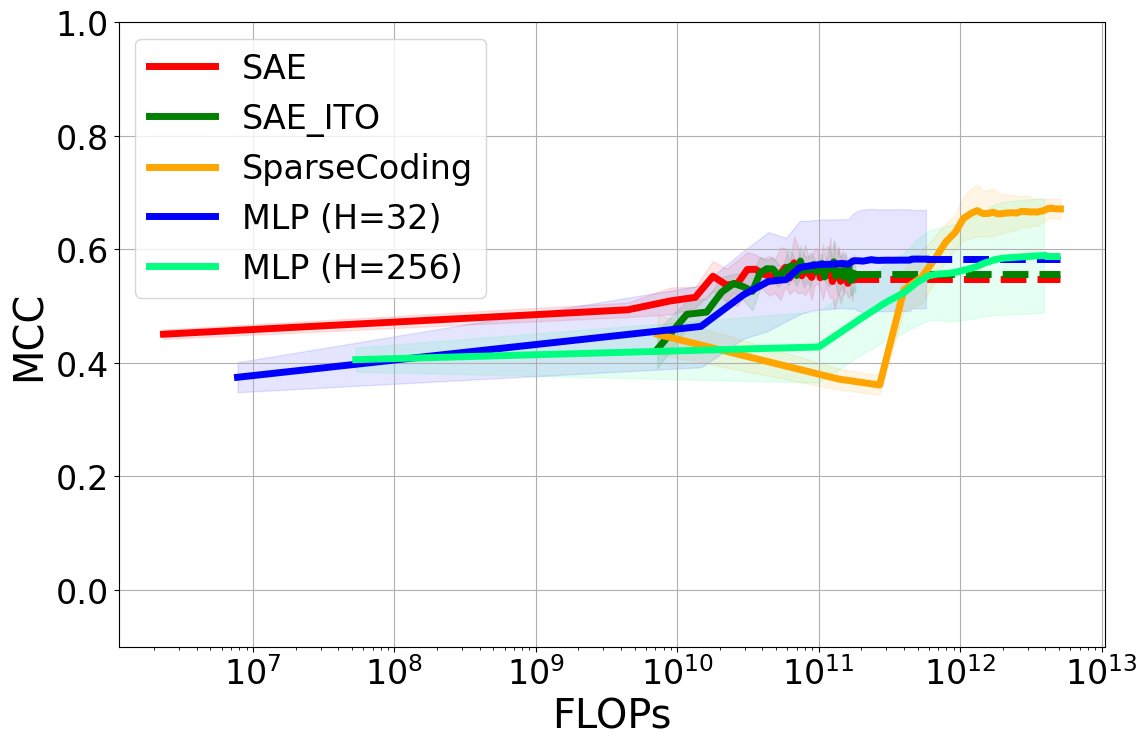

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_mcc = np.array(data['SAE']['mcc_test'])
sae_mcc_std = np.array(data['SAE']['mcc_test_std'])

plt.plot(sae_flops, sae_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_mcc - sae_mcc_std, sae_mcc + sae_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_mcc[-1], sae_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_mcc = np.array(data['SAE_ITO']['mcc_test'])
sae_ito_mcc_std = np.array(data['SAE_ITO']['mcc_test_std'])

plt.plot(sae_ito_flops, sae_ito_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_mcc - sae_ito_mcc_std, sae_ito_mcc + sae_ito_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_mcc[-1], sae_ito_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_mcc = np.array(data['SparseCoding']['mcc_test'])
sc_mcc_std = np.array(data['SparseCoding']['mcc_test_std'])

plt.plot(sc_flops, sc_mcc, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_mcc - sc_mcc_std, sc_mcc + sc_mcc_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_mcc[-1], sc_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_mcc = np.array(mlp_data['mcc_test'])
    mlp_mcc_std = np.array(mlp_data['mcc_test_std'])
    
    plt.plot(mlp_flops, mlp_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_mcc - mlp_mcc_std, mlp_mcc + mlp_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_mcc[-1], mlp_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_flops_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

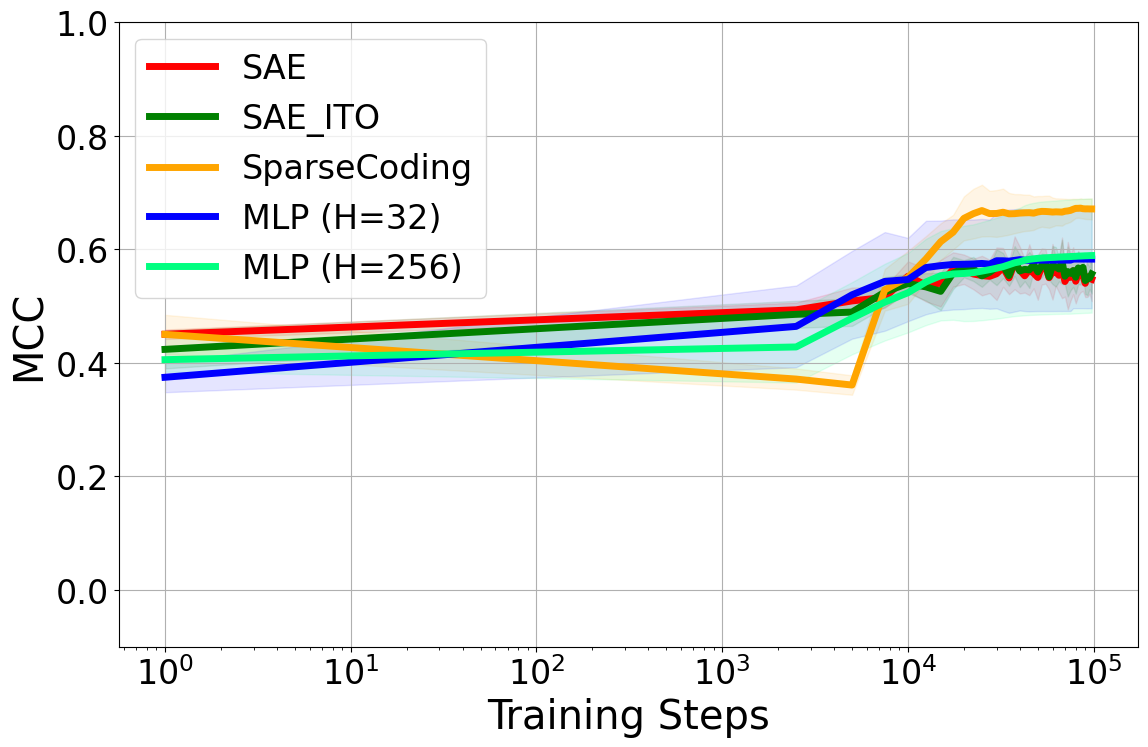

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['mcc_test'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['mcc_test']) - np.array(avg_sae['mcc_test_std']),
                 np.array(avg_sae['mcc_test']) + np.array(avg_sae['mcc_test_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['mcc_test'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['mcc_test']) - np.array(avg_sae_ito['mcc_test_std']),
                 np.array(avg_sae_ito['mcc_test']) + np.array(avg_sae_ito['mcc_test_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['mcc_test'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['mcc_test']) - np.array(avg_sparse_coding['mcc_test_std']),
                 np.array(avg_sparse_coding['mcc_test']) + np.array(avg_sparse_coding['mcc_test_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['mcc_test'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['mcc_test']) - np.array(avg_mlp['mcc_test_std']),
                     np.array(avg_mlp['mcc_test']) + np.array(avg_mlp['mcc_test_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_training_steps_reconstruction.pdf', dpi=300, bbox_inches='tight')
plt.show()

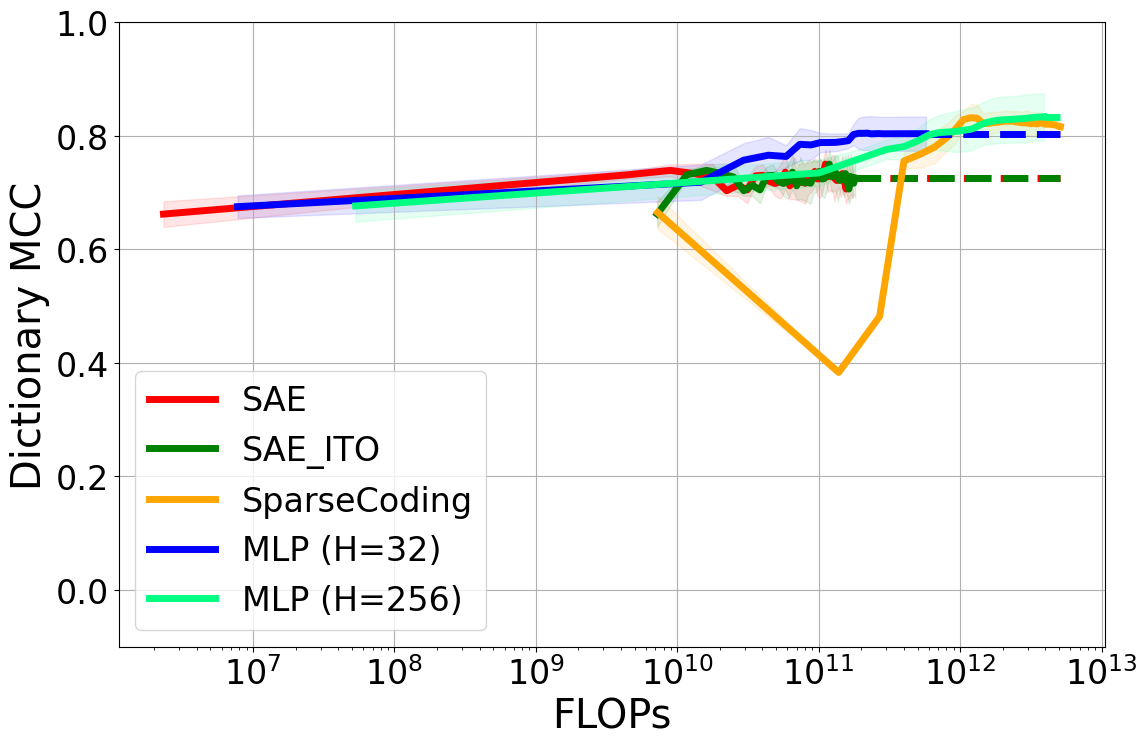

In [28]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Find the maximum FLOPs value across all models
max_flops = max(
    data['SAE']['train_flops'][-1] + data['SAE']['test_flops'][-1],
    data['SAE_ITO']['train_flops'][-1] + data['SAE_ITO']['test_flops'][-1],
    data['SparseCoding']['train_flops'][-1] + data['SparseCoding']['test_flops'][-1],
    max(data['MLPs'][h]['train_flops'][-1] + data['MLPs'][h]['test_flops'][-1] for h in data['MLPs'])
)

# Plot SAE
sae_flops = np.array(data['SAE']['train_flops']) + np.array(data['SAE']['test_flops'])
sae_dict_mcc = np.array(data['SAE']['dict_mcc'])
sae_dict_mcc_std = np.array(data['SAE']['dict_mcc_std'])

plt.plot(sae_flops, sae_dict_mcc, '-', color='red', label='SAE', linewidth=linewidth)
plt.fill_between(sae_flops, sae_dict_mcc - sae_dict_mcc_std, sae_dict_mcc + sae_dict_mcc_std, alpha=alpha, color='red')
# Extend SAE line
plt.plot([sae_flops[-1], max_flops], [sae_dict_mcc[-1], sae_dict_mcc[-1]], '--', color='red', linewidth=linewidth)

# Plot SAE_ITO
sae_ito_flops = np.array(data['SAE_ITO']['train_flops']) + np.array(data['SAE_ITO']['test_flops'])
sae_ito_dict_mcc = np.array(data['SAE_ITO']['dict_mcc'])
sae_ito_dict_mcc_std = np.array(data['SAE_ITO']['dict_mcc_std'])

plt.plot(sae_ito_flops, sae_ito_dict_mcc, '-', color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(sae_ito_flops, sae_ito_dict_mcc - sae_ito_dict_mcc_std, sae_ito_dict_mcc + sae_ito_dict_mcc_std, alpha=alpha, color='green')
# Extend SAE_ITO line
plt.plot([sae_ito_flops[-1], max_flops], [sae_ito_dict_mcc[-1], sae_ito_dict_mcc[-1]], '--', color='green', linewidth=linewidth)

# Plot SparseCoding
sc_flops = np.array(data['SparseCoding']['train_flops']) + np.array(data['SparseCoding']['test_flops'])
sc_dict_mcc = np.array(data['SparseCoding']['dict_mcc'])
sc_dict_mcc_std = np.array(data['SparseCoding']['dict_mcc_std'])

plt.plot(sc_flops, sc_dict_mcc, '-', color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(sc_flops, sc_dict_mcc - sc_dict_mcc_std, sc_dict_mcc + sc_dict_mcc_std, alpha=alpha, color='orange')
# Extend SparseCoding line
plt.plot([sc_flops[-1], max_flops], [sc_dict_mcc[-1], sc_dict_mcc[-1]], '--', color='orange', linewidth=linewidth)

# Plot MLPs
hidden_layers = list(data['MLPs'].keys())
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))

for h, color in zip(hidden_layers, colors):
    mlp_data = data['MLPs'][h]
    mlp_flops = np.array(mlp_data['train_flops']) + np.array(mlp_data['test_flops'])
    mlp_dict_mcc = np.array(mlp_data['dict_mcc'])
    mlp_dict_mcc_std = np.array(mlp_data['dict_mcc_std'])
    
    plt.plot(mlp_flops, mlp_dict_mcc, '-', color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(mlp_flops, mlp_dict_mcc - mlp_dict_mcc_std, mlp_dict_mcc + mlp_dict_mcc_std, alpha=alpha, color=color)
    # Extend MLP line
    plt.plot([mlp_flops[-1], max_flops], [mlp_dict_mcc[-1], mlp_dict_mcc[-1]], '--', color=color, linewidth=linewidth)

plt.xscale('log')
plt.xlabel('FLOPs', fontsize=base_fontsize * 1.2)
plt.ylabel('Dictionary MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_flops_dict_mcc.pdf', dpi=300, bbox_inches='tight')
plt.show()

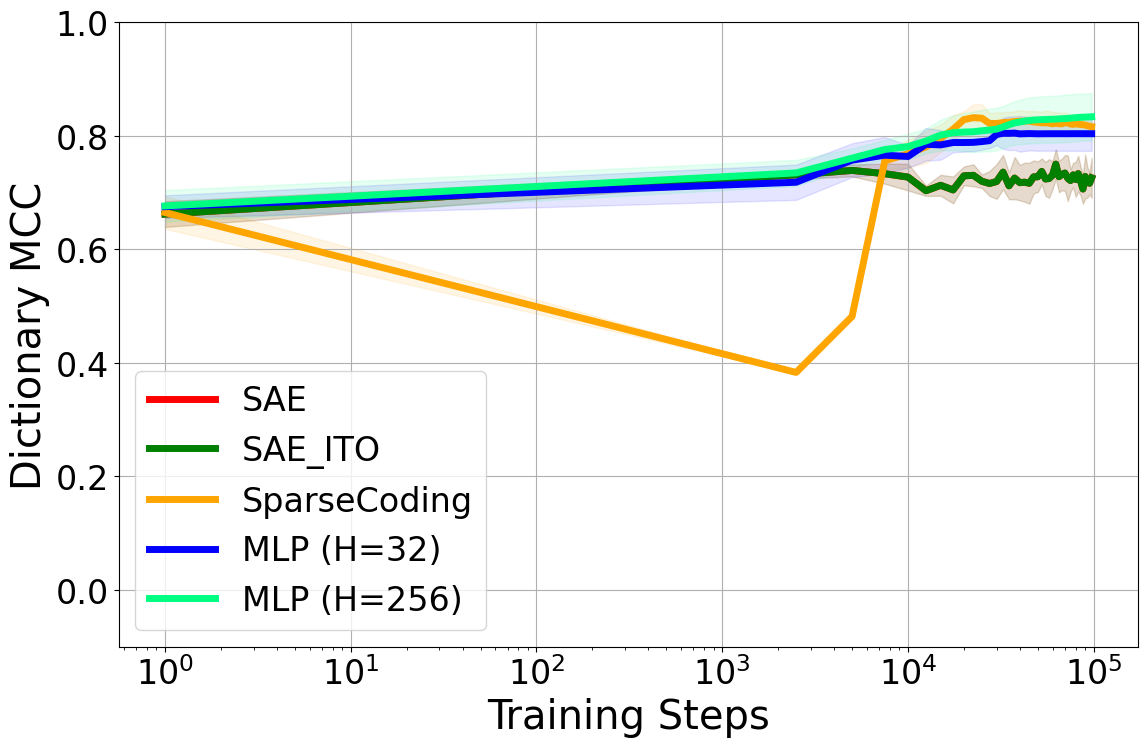

In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('results/unknown_Z_D_flops_reconstruction.json', 'r') as f:
    data = json.load(f)

# Extract data
avg_sae = data['SAE']
avg_sae_ito = data['SAE_ITO']
avg_sparse_coding = data['SparseCoding']
avg_mlps = data['MLPs']
hidden_layers = list(avg_mlps.keys())

# Plot results
base_fontsize = 24  # Parameterized base font size
linewidth = 5  # Parameterized line width
alpha = 0.1  # Set alpha to 0.1

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': base_fontsize})

# Plot SAE
plt.plot(np.array(avg_sae['step']) + 1, avg_sae['dict_mcc'], '-',
         color='red', label='SAE', linewidth=linewidth)
plt.fill_between(np.array(avg_sae['step']) + 1,
                 np.array(avg_sae['dict_mcc']) - np.array(avg_sae['dict_mcc_std']),
                 np.array(avg_sae['dict_mcc']) + np.array(avg_sae['dict_mcc_std']),
                 alpha=alpha, color='red')

# Plot SAE_ITO
plt.plot(np.array(avg_sae_ito['step']) + 1, avg_sae_ito['dict_mcc'], '-',
         color='green', label='SAE_ITO', linewidth=linewidth)
plt.fill_between(np.array(avg_sae_ito['step']) + 1,
                 np.array(avg_sae_ito['dict_mcc']) - np.array(avg_sae_ito['dict_mcc_std']),
                 np.array(avg_sae_ito['dict_mcc']) + np.array(avg_sae_ito['dict_mcc_std']),
                 alpha=alpha, color='green')

# Plot SparseCoding
plt.plot(np.array(avg_sparse_coding['step']) + 1, avg_sparse_coding['dict_mcc'], '-',
         color='orange', label='SparseCoding', linewidth=linewidth)
plt.fill_between(np.array(avg_sparse_coding['step']) + 1,
                 np.array(avg_sparse_coding['dict_mcc']) - np.array(avg_sparse_coding['dict_mcc_std']),
                 np.array(avg_sparse_coding['dict_mcc']) + np.array(avg_sparse_coding['dict_mcc_std']),
                 alpha=alpha, color='orange')

# Plot MLPs
colors = plt.cm.winter(np.linspace(0, 1, len(hidden_layers)))
for h, color in zip(hidden_layers, colors):
    avg_mlp = avg_mlps[h]
    plt.plot(np.array(avg_mlp['step']) + 1, avg_mlp['dict_mcc'], '-',
             color=color, label=f'MLP (H={h})', linewidth=linewidth)
    plt.fill_between(np.array(avg_mlp['step']) + 1,
                     np.array(avg_mlp['dict_mcc']) - np.array(avg_mlp['dict_mcc_std']),
                     np.array(avg_mlp['dict_mcc']) + np.array(avg_mlp['dict_mcc_std']),
                     alpha=alpha, color=color)

plt.xscale('log')
plt.xlabel('Training Steps', fontsize=base_fontsize * 1.2)
plt.ylabel('Dictionary MCC', fontsize=base_fontsize * 1.2)
plt.legend(fontsize=base_fontsize)
plt.grid(True)
plt.ylim(-0.1, 1)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=base_fontsize)

plt.tight_layout()
plt.savefig('results/figures/unknown_Z_D_training_steps_dict_mcc.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Debugging

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('..')

# Assuming these functions are defined elsewhere
from experiments import generate_data
from metrics import mcc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parameters
N = 16  # number of sparse sources
M = 8   # number of measurements
K = 3   # number of active components
num_data = 1024
seed = 20240925
num_step = 20_000

class SparseCoding(nn.Module):
    def __init__(self, X, D, learn_D, seed=20240925):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        if learn_D:
            self.D = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D = nn.Parameter(data=D, requires_grad=False)
        self.log_S = nn.Parameter(data=-10 * torch.ones(X.shape[0], D.shape[0]), requires_grad=True)

    def forward(self, X):
        if self.learn_D:
            self.D.data /= torch.linalg.norm(self.D.data, dim=1, keepdim=True)
        S = torch.exp(self.log_S)
        X_ = S @ self.D
        return S, X_

def reconstruction_loss_with_l1(X, X_, S_, l1_weight=0.01):
    loss = torch.sum((X - X_) ** 2) + l1_weight * torch.sum(torch.abs(S_))
    return loss

def train_sparse_coding(model, X, S, num_step=30000):
    optim = torch.optim.Adam(model.parameters(), lr=3e-3)
    
    for i in range(num_step):
        S_, X_ = model(X)
        loss = reconstruction_loss_with_l1(X, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i % 1000 == 0:
            train_mcc = mcc(S.cpu().numpy(), S_.detach().cpu().numpy())
            print(f"Step {i}: Loss = {loss.item():.4f} Train MCC = {train_mcc:.4f}")
    
    return model

# Generate data
S, X, D = generate_data(N, M, K, num_data, seed=seed)

# Create and train the model
model = SparseCoding(X, D, learn_D=True, seed=seed).to(device)
trained_model = train_sparse_coding(model, X, S, num_step=num_step)

print("Training completed.")

Step 0: Loss = 3173.1597 Train MCC = 0.0000
Step 1000: Loss = 2773.8567 Train MCC = 0.3186
Step 2000: Loss = 165.3747 Train MCC = 0.5913
Step 3000: Loss = 44.0571 Train MCC = 0.6175
Step 4000: Loss = 37.1701 Train MCC = 0.6385
Step 5000: Loss = 34.4708 Train MCC = 0.6714
Step 6000: Loss = 32.7174 Train MCC = 0.6979
Step 7000: Loss = 31.4013 Train MCC = 0.7242


KeyboardInterrupt: 

In [4]:
# %%
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as corr
import pickle
from tqdm import tqdm
import sys
from munkres import Munkres
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gennorm
from typing import Union

from scipy.fft import dct

from metrics import mcc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

# %%
# parameters
N = 16  # number of sparse sources
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
lr = 3e-3
num_step = 20000
weight = 1e-2


def criterion(S_, X, X_, weight=weight):
    loss = torch.sum((X - X_) ** 2) + weight * torch.sum(torch.abs(S_))
    return loss

class SparseCoding(nn.Module):
    def __init__(self, S, D, learn_D, seed=seed):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(S.shape), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_

def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model.forward(X)
        loss = criterion(S_, X, X_, weight=weight)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % 1000:
            # Print D_
            if not torch.all(S_.var(0) > 0):
                print('dead latents')
            print(f'step {i}, loss {loss.item():.4f}, '
                  f'MCC {mcc(S.detach().cpu().numpy(), S_.detach().cpu().numpy()):.4f}')
    print('final MCC', mcc(S.detach().cpu().numpy(), S_.detach().cpu().numpy()))
    return S_

torch.manual_seed(seed)
#S, X, D = generate_data(N, M, K, num_data, seed=seed)
print(S.shape, X.shape, D.shape)

# 
sc0 = SparseCoding(S, D, learn_D=True, seed=seed).to(device)
S_ = train(sc0)

using cpu
torch.Size([1024, 16]) torch.Size([1024, 8]) torch.Size([16, 8])
step 1000, loss 2759.4897, MCC 0.3050
step 2000, loss 186.3278, MCC 0.5560
step 3000, loss 46.5634, MCC 0.6061
step 4000, loss 37.8071, MCC 0.6511
step 5000, loss 34.3759, MCC 0.6934
step 6000, loss 32.1603, MCC 0.7402
step 7000, loss 30.2994, MCC 0.7939
step 8000, loss 28.4424, MCC 0.8491
step 9000, loss 27.1028, MCC 0.8810
step 10000, loss 26.6628, MCC 0.8899
step 11000, loss 26.9043, MCC 0.8891
step 12000, loss 27.5940, MCC 0.8935
step 13000, loss 27.8359, MCC 0.9000
step 14000, loss 28.3828, MCC 0.8921
step 15000, loss 28.8028, MCC 0.8779
step 16000, loss 29.0104, MCC 0.8608
step 17000, loss 29.4387, MCC 0.8375
step 18000, loss 29.7480, MCC 0.8097
step 19000, loss 29.7556, MCC 0.7936
final MCC 0.789343745392669


## Scaling laws

## Varying $N$ and $M$

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import SparseAutoEncoder, MLP, SparseCoding
from metrics import mcc, greedy_mcc
from utils import numpy_to_list, generate_data, reconstruction_loss_with_l1
from calculate_flops import (calculate_sae_training_flops, calculate_sae_inference_flops, 
                             calculate_mlp_training_flops, calculate_mlp_inference_flops, 
                             calculate_sparse_coding_training_flops, calculate_sparse_coding_inference_flops)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=100_000, log_step=2500):
    if isinstance(model, SparseCoding):
        return train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:
        return train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=100_000, log_step=2500):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    best_mcc = 0
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
            mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
            if mcc_test > best_mcc:
                best_mcc = mcc_test
            print(f'step {i}, loss {loss.item():.4f}, mcc test {mcc_test:.4f}')
    return best_mcc

def train(model, X_train, S_train, X_test, S_test, D_true, lr=1e-3, num_step=30000, log_step=100):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    best_mcc = 0
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            with torch.no_grad():
                S_, X_ = model(X_test)
            mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
            if mcc_test > best_mcc:
                best_mcc = mcc_test
            print(f'step {i}, loss {loss.item():.4f}, mcc test {mcc_test:.4f}')
    return best_mcc

def scaling_laws_experiment(N_values, M_values, K, num_data=1024, num_step=30000, log_step=100, seed=20240927):
    results = {method: {M: [] for M in M_values} for method in ['SAE', 'MLP', 'SparseCoding']}
    
    for M in M_values:
        for N in N_values:
            torch.manual_seed(seed)
            np.random.seed(seed)

            print(f'N: {N}, M: {M}') 
            print('-' * 80)
            
            # Generate data
            S, X, D = generate_data(N, M, K, num_data * 2, seed=seed)
            S_train, X_train = S[:num_data].to(device), X[:num_data].to(device)
            S_test, X_test = S[num_data:].to(device), X[num_data:].to(device)
            D_true = D.to(device)

            # Sparse Coding
            print('SparseCoding')
            sc = SparseCoding(X_test, D=D_true, learn_D=True, seed=seed).to(device)
            sc_mcc = run_experiment(sc, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            results['SparseCoding'][M].append(sc_mcc)
            
            # SAE
            print('SAE')
            sae = SparseAutoEncoder(M, N, D=D_true, learn_D=True, seed=seed).to(device)
            sae_mcc = run_experiment(sae, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            results['SAE'][M].append(sae_mcc)
            
            # MLP (using hidden layer size of 256)
            print('MLP')
            mlp = MLP(M, N, h=256, D=D_true, learn_D=True, seed=seed).to(device)
            mlp_mcc = run_experiment(mlp, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
            results['MLP'][M].append(mlp_mcc)
            
            print(f"Completed N={N}, M={M}")
    
    return results

# Parameters
N_values = [16, 32, 64, 128, 256]
M_values = [8, 16, 32]
K = 3
num_data = 1024
num_step = 100_000
log_step = 10_000
seed = 20240927

# Run experiment
results = scaling_laws_experiment(N_values, M_values, K, num_data, num_step, log_step, seed)

In [52]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import SparseAutoEncoder, MLP, SparseCoding
from metrics import mcc, greedy_mcc
from utils import numpy_to_list, generate_data, reconstruction_loss_with_l1
from calculate_flops import (calculate_sae_training_flops, calculate_sae_inference_flops, calculate_optimize_codes_flops,
                             calculate_mlp_training_flops, calculate_mlp_inference_flops, 
                             calculate_sparse_coding_training_flops, calculate_sparse_coding_inference_flops)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calculate_dict_mcc(D_true, D_learned):
    return greedy_mcc(D_true.T.cpu().numpy(), D_learned.T.cpu().numpy())

def run_experiment(model, X_train, S_train, X_test, S_test, D_true, num_step=100_000, log_step=2500):
    if isinstance(model, SparseCoding):
        return train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
    else:
        return train(model, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)

def train_sparse_coding(model, X_train, S_train, X_test, S_test, D_true, lr=3e-3, num_step=100_000, log_step=2500):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            print(f'step {i}, loss {loss.item():.4f}')
    
    # Final evaluation
    S_test_opt = model.optimize_codes(X_test, num_iterations=10_000)
    mcc_test = mcc(S_test.cpu().numpy(), S_test_opt.cpu().numpy())
    dict_mcc = calculate_dict_mcc(D_true, model.D.data)
    
    # Calculate FLOPs
    train_flops = calculate_sparse_coding_training_flops(X_train.shape[1], model.D.shape[1], X_train.shape[0], num_step, learn_D=True)
    test_flops = calculate_optimize_codes_flops(X_test.shape[1], model.D.shape[1], X_test.shape[0], 10_000)
    
    print(f'Final mcc test {mcc_test:.4f}, dict mcc {dict_mcc:.4f}')
    return mcc_test, dict_mcc, train_flops, test_flops

def train(model, X_train, S_train, X_test, S_test, D_true, lr=3e-3, num_step=100_000, log_step=2500):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model(X_train)
        loss = reconstruction_loss_with_l1(X_train, X_, S_)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % log_step == 0:
            print(f'step {i}, loss {loss.item():.4f}')
    
    # Final evaluation
    with torch.no_grad():
        S_, X_ = model(X_test)
    mcc_test = mcc(S_test.detach().cpu().numpy(), S_.detach().cpu().numpy())
    dict_mcc = calculate_dict_mcc(D_true, model.decoder.weight.data.T)
    
    # Calculate FLOPs
    if isinstance(model, SparseAutoEncoder):
        train_flops = calculate_sae_training_flops(X_train.shape[1], model.decoder.weight.shape[1], X_train.shape[0], num_step, learn_D=True)
        test_flops = calculate_sae_inference_flops(X_test.shape[1], model.decoder.weight.shape[1], X_test.shape[0])
    elif isinstance(model, MLP):
        h = model.encoder[0].out_features
        train_flops = calculate_mlp_training_flops(X_train.shape[1], h, model.decoder.weight.shape[1], X_train.shape[0], num_step, learn_D=True)
        test_flops = calculate_mlp_inference_flops(X_test.shape[1], h, model.decoder.weight.shape[1], X_test.shape[0])
    
    print(f'Final mcc test {mcc_test:.4f}, dict mcc {dict_mcc:.4f}')
    return mcc_test, dict_mcc, train_flops, test_flops

def scaling_laws_experiment(N_values, M_values, K, num_data=1024, num_step=100_000, log_step=2500, seed=20240927, num_runs=3):
    results = {method: {M: [] for M in M_values} for method in ['SAE', 'MLP', 'SparseCoding']}
    
    for M in M_values:
        for N in tqdm(N_values, desc='N'):
            print(f'N: {N}, M: {M}') 
            print('-' * 80)
            
            sc_mccs, sc_dict_mccs = [], []
            sae_mccs, sae_dict_mccs = [], []
            mlp_mccs, mlp_dict_mccs = [], []
            
            for run in range(num_runs):
                print(f'Run {run + 1}/{num_runs}')
                run_seed = seed + run
                torch.manual_seed(run_seed)
                np.random.seed(run_seed)
                
                # Generate data
                S, X, D = generate_data(N, M, K, num_data * 2, seed=run_seed)
                S_train, X_train = S[:num_data].to(device), X[:num_data].to(device)
                S_test, X_test = S[num_data:].to(device), X[num_data:].to(device)
                D_true = D.to(device)

                # Sparse Coding
                print('SparseCoding')
                sc = SparseCoding(X_test, D=D_true, learn_D=True, seed=run_seed).to(device)
                sc_mcc, sc_dict_mcc, sc_train_flops, sc_test_flops = run_experiment(sc, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
                sc_mccs.append(sc_mcc)
                sc_dict_mccs.append(sc_dict_mcc)
                
                # SAE
                print('SAE')
                sae = SparseAutoEncoder(M, N, D=D_true, learn_D=True, seed=run_seed).to(device)
                sae_mcc, sae_dict_mcc, sae_train_flops, sae_test_flops = run_experiment(sae, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
                sae_mccs.append(sae_mcc)
                sae_dict_mccs.append(sae_dict_mcc)
                
                # MLP (using hidden layer size of 32)
                print('MLP')
                mlp = MLP(M, N, h=32, D=D_true, learn_D=True, seed=run_seed).to(device)
                mlp_mcc, mlp_dict_mcc, mlp_train_flops, mlp_test_flops = run_experiment(mlp, X_train, S_train, X_test, S_test, D_true, num_step=num_step, log_step=log_step)
                mlp_mccs.append(mlp_mcc)
                mlp_dict_mccs.append(mlp_dict_mcc)
            
            # Average MCCs and store results
            results['SparseCoding'][M].append((N, np.mean(sc_mccs), np.std(sc_mccs), np.mean(sc_dict_mccs), np.std(sc_dict_mccs), sc_train_flops, sc_test_flops))
            results['SAE'][M].append((N, np.mean(sae_mccs), np.std(sae_mccs), np.mean(sae_dict_mccs), np.std(sae_dict_mccs), sae_train_flops, sae_test_flops))
            results['MLP'][M].append((N, np.mean(mlp_mccs), np.std(mlp_mccs), np.mean(mlp_dict_mccs), np.std(mlp_dict_mccs), mlp_train_flops, mlp_test_flops))
            
            print(f"Completed N={N}, M={M}")
    
    return results

# Parameters
N_values = [16, 32, 64, 128]
M_values = [8, 16, 32]
K = 3
num_data = 1024
num_step = 50_000
log_step = 25_000
seed = 20240927
num_runs = 3

# Run experiment
results = scaling_laws_experiment(N_values, M_values, K, num_data, num_step, log_step, seed, num_runs)

# Save results
with open(f'results/scaling_laws_K_{K}.json', 'w') as f:
    json.dump(results, f, indent=2)

N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.3669
step 25000, loss 0.0029
Final mcc test 0.7587, dict mcc 0.8878
SAE
step 0, loss 0.6060
step 25000, loss 0.0026
Final mcc test 0.5647, dict mcc 0.7535
MLP
step 0, loss 0.3825
step 25000, loss 0.0020
Final mcc test 0.6197, dict mcc 0.8190
Run 2/3
SparseCoding
step 0, loss 0.3959
step 25000, loss 0.0031
Final mcc test 0.6453, dict mcc 0.7892
SAE
step 0, loss 0.6377
step 25000, loss 0.0021
Final mcc test 0.6294, dict mcc 0.6935
MLP
step 0, loss 0.4360
step 25000, loss 0.0020
Final mcc test 0.5989, dict mcc 0.7983
Run 3/3
SparseCoding
step 0, loss 0.3826
step 25000, loss 0.0029
Final mcc test 0.7004, dict mcc 0.8245
SAE
step 0, loss 0.6249
step 25000, loss 0.0022
Final mcc test 0.6389, dict mcc 0.7736
MLP
step 0, loss 0.4334
step 25000, loss 0.0019


N:  25%|██▌       | 1/4 [03:03<09:09, 183.09s/it]

Final mcc test 0.6739, dict mcc 0.8498
Completed N=16, M=8
N: 32, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.3609
step 25000, loss 0.0019
Final mcc test 0.5173, dict mcc 0.8027
SAE
step 0, loss 0.6740
step 25000, loss 0.0011
Final mcc test 0.3237, dict mcc 0.7585
MLP
step 0, loss 0.4739
step 25000, loss 0.0009
Final mcc test 0.4996, dict mcc 0.8234
Run 2/3
SparseCoding
step 0, loss 0.3634
step 25000, loss 0.0019
Final mcc test 0.5184, dict mcc 0.8323
SAE
step 0, loss 0.7974
step 25000, loss 0.0010
Final mcc test 0.3973, dict mcc 0.7561
MLP
step 0, loss 0.4270
step 25000, loss 0.0010
Final mcc test 0.4213, dict mcc 0.7954
Run 3/3
SparseCoding
step 0, loss 0.3595
step 25000, loss 0.0018
Final mcc test 0.5839, dict mcc 0.8514
SAE
step 0, loss 0.8309
step 25000, loss 0.0010
Final mcc test 0.4153, dict mcc 0.7783
MLP
step 0, loss 0.4492
step 25000, loss 0.0010


N:  50%|█████     | 2/4 [05:53<05:51, 175.63s/it]

Final mcc test 0.4555, dict mcc 0.8006
Completed N=32, M=8
N: 64, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.3784
step 25000, loss 0.0012
Final mcc test 0.4423, dict mcc 0.8319
SAE
step 0, loss 1.1747
step 25000, loss 0.0005
Final mcc test 0.2399, dict mcc 0.8094
MLP
step 0, loss 0.4785
step 25000, loss 0.0005
Final mcc test 0.2782, dict mcc 0.8198
Run 2/3
SparseCoding
step 0, loss 0.3964
step 25000, loss 0.0012
Final mcc test 0.4487, dict mcc 0.8505
SAE
step 0, loss 0.9615
step 25000, loss 0.0006
Final mcc test 0.2503, dict mcc 0.7906
MLP
step 0, loss 0.4569
step 25000, loss 0.0005
Final mcc test 0.2609, dict mcc 0.8020
Run 3/3
SparseCoding
step 0, loss 0.3710
step 25000, loss 0.0012
Final mcc test 0.4474, dict mcc 0.8461
SAE
step 0, loss 1.2045
step 25000, loss 0.0005
Final mcc test 0.2413, dict mcc 0.8026
MLP
step 0, loss 0.4615
step 25000, loss 0.0005


N:  75%|███████▌  | 3/4 [12:50<04:45, 285.74s/it]

Final mcc test 0.2167, dict mcc 0.8087
Completed N=64, M=8
N: 128, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.3761
step 25000, loss 0.0008
Final mcc test 0.3862, dict mcc 0.8694
SAE
step 0, loss 1.8930
step 25000, loss 0.0003
Final mcc test 0.2088, dict mcc 0.8194
MLP
step 0, loss 0.5742
step 25000, loss 0.0003
Final mcc test 0.2372, dict mcc 0.8248
Run 2/3
SparseCoding
step 0, loss 0.3705
step 25000, loss 0.0008
Final mcc test 0.3971, dict mcc 0.8630
SAE
step 0, loss 2.0595
step 25000, loss 0.0003
Final mcc test 0.1937, dict mcc 0.8383
MLP
step 0, loss 0.9754
step 25000, loss 0.0003
Final mcc test 0.2364, dict mcc 0.8126
Run 3/3
SparseCoding
step 0, loss 0.3621
step 25000, loss 0.0008
Final mcc test 0.3858, dict mcc 0.8687
SAE
step 0, loss 1.8218
step 25000, loss 0.0003
Final mcc test 0.2234, dict mcc 0.8256
MLP
step 0, loss 0.5121
step 25000, loss 0.0003


N: 100%|██████████| 4/4 [23:40<00:00, 355.02s/it]


Final mcc test 0.2356, dict mcc 0.8244
Completed N=128, M=8


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.1810
step 25000, loss 0.0019
Final mcc test 0.9609, dict mcc 0.9839
SAE
step 0, loss 0.2218
step 25000, loss 0.0015
Final mcc test 0.9981, dict mcc 0.9986
MLP
step 0, loss 0.1977
step 25000, loss 0.0015
Final mcc test 0.9999, dict mcc 1.0000
Run 2/3
SparseCoding
step 0, loss 0.1927
step 25000, loss 0.0024
Final mcc test 0.8903, dict mcc 0.9078
SAE
step 0, loss 0.2626
step 25000, loss 0.0015
Final mcc test 0.9937, dict mcc 0.9920
MLP
step 0, loss 0.2380
step 25000, loss 0.0019
Final mcc test 0.8702, dict mcc 0.9105
Run 3/3
SparseCoding
step 0, loss 0.1844
step 25000, loss 0.0019
Final mcc test 0.9595, dict mcc 0.9855
SAE
step 0, loss 0.2475
step 25000, loss 0.0022
Final mcc test 0.8390, dict mcc 0.9188
MLP
step 0, loss 0.2333
step 25000, loss 0.0015


N:  25%|██▌       | 1/4 [02:24<07:14, 144.88s/it]

Final mcc test 0.9999, dict mcc 1.0000
Completed N=16, M=16
N: 32, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.1886
step 25000, loss 0.0014
Final mcc test 0.8996, dict mcc 0.9747
SAE
step 0, loss 0.2847
step 25000, loss 0.0014
Final mcc test 0.6186, dict mcc 0.6833
MLP
step 0, loss 0.2164
step 25000, loss 0.0014
Final mcc test 0.6140, dict mcc 0.7377
Run 2/3
SparseCoding
step 0, loss 0.1782
step 25000, loss 0.0015
Final mcc test 0.8640, dict mcc 0.9393
SAE
step 0, loss 0.2567
step 25000, loss 0.0013
Final mcc test 0.6076, dict mcc 0.7164
MLP
step 0, loss 0.1907
step 25000, loss 0.0017
Final mcc test 0.4761, dict mcc 0.6704
Run 3/3
SparseCoding
step 0, loss 0.1808
step 25000, loss 0.0015
Final mcc test 0.8953, dict mcc 0.9659
SAE
step 0, loss 0.3276
step 25000, loss 0.0013
Final mcc test 0.6140, dict mcc 0.6908
MLP
step 0, loss 0.1928
step 25000, loss 0.0017


N:  50%|█████     | 2/4 [05:20<05:26, 163.09s/it]

Final mcc test 0.4820, dict mcc 0.6774
Completed N=32, M=16
N: 64, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.1912
step 25000, loss 0.0013
Final mcc test 0.7291, dict mcc 0.8792
SAE
step 0, loss 0.3714
step 25000, loss 0.0007
Final mcc test 0.3303, dict mcc 0.6663
MLP
step 0, loss 0.2268
step 25000, loss 0.0007
Final mcc test 0.3943, dict mcc 0.6829
Run 2/3
SparseCoding
step 0, loss 0.1928
step 25000, loss 0.0014
Final mcc test 0.7252, dict mcc 0.8709
SAE
step 0, loss 0.3711
step 25000, loss 0.0007
Final mcc test 0.3779, dict mcc 0.6801
MLP
step 0, loss 0.2778
step 25000, loss 0.0007
Final mcc test 0.4148, dict mcc 0.6834
Run 3/3
SparseCoding
step 0, loss 0.1894
step 25000, loss 0.0012
Final mcc test 0.7522, dict mcc 0.9093
SAE
step 0, loss 0.3465
step 25000, loss 0.0007
Final mcc test 0.4068, dict mcc 0.6696
MLP
step 0, loss 0.2291
step 25000, loss 0.0010


N:  75%|███████▌  | 3/4 [12:24<04:42, 282.22s/it]

Final mcc test 0.3431, dict mcc 0.6277
Completed N=64, M=16
N: 128, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.1894
step 25000, loss 0.0010
Final mcc test 0.5030, dict mcc 0.7764
SAE
step 0, loss 0.4917
step 25000, loss 0.0004
Final mcc test 0.2580, dict mcc 0.6661
MLP
step 0, loss 0.2916
step 25000, loss 0.0004
Final mcc test 0.2893, dict mcc 0.6504
Run 2/3
SparseCoding
step 0, loss 0.1838
step 25000, loss 0.0011
Final mcc test 0.4788, dict mcc 0.7652
SAE
step 0, loss 0.5059
step 25000, loss 0.0004
Final mcc test 0.2675, dict mcc 0.6639
MLP
step 0, loss 0.2814
step 25000, loss 0.0004
Final mcc test 0.2786, dict mcc 0.6554
Run 3/3
SparseCoding
step 0, loss 0.1824
step 25000, loss 0.0011
Final mcc test 0.4967, dict mcc 0.7675
SAE
step 0, loss 0.5581
step 25000, loss 0.0004
Final mcc test 0.2855, dict mcc 0.6670
MLP
step 0, loss 0.3192
step 25000, loss 0.0004


N: 100%|██████████| 4/4 [23:38<00:00, 354.54s/it]


Final mcc test 0.2432, dict mcc 0.6467
Completed N=128, M=16


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.0897
step 25000, loss 0.0018
Final mcc test 0.9508, dict mcc 0.9686
SAE
step 0, loss 0.1066
step 25000, loss 0.0015
Final mcc test 1.0000, dict mcc 0.9998
MLP
step 0, loss 0.1237
step 25000, loss 0.0026
Final mcc test 0.8627, dict mcc 0.9394
Run 2/3
SparseCoding
step 0, loss 0.0983
step 25000, loss 0.0022
Final mcc test 0.8907, dict mcc 0.8998
SAE
step 0, loss 0.1095
step 25000, loss 0.0015
Final mcc test 0.9999, dict mcc 0.9998
MLP
step 0, loss 0.1229
step 25000, loss 0.0024
Final mcc test 0.8899, dict mcc 0.9230
Run 3/3
SparseCoding
step 0, loss 0.0932
step 25000, loss 0.0023
Final mcc test 0.9137, dict mcc 0.9323
SAE
step 0, loss 0.1161
step 25000, loss 0.0015
Final mcc test 1.0000, dict mcc 0.9999
MLP
step 0, loss 0.1265
step 25000, loss 0.0039


N:  25%|██▌       | 1/4 [02:44<08:12, 164.02s/it]

Final mcc test 0.7519, dict mcc 0.8733
Completed N=16, M=32
N: 32, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.0944
step 25000, loss 0.0013
Final mcc test 0.8787, dict mcc 0.9466
SAE
step 0, loss 0.1152
step 25000, loss 0.0008
Final mcc test 0.9995, dict mcc 1.0000
MLP
step 0, loss 0.1133
step 25000, loss 0.0013
Final mcc test 0.7842, dict mcc 0.8821
Run 2/3
SparseCoding
step 0, loss 0.0882
step 25000, loss 0.0011
Final mcc test 0.8960, dict mcc 0.9557
SAE
step 0, loss 0.1112
step 25000, loss 0.0007
Final mcc test 0.9989, dict mcc 1.0000
MLP
step 0, loss 0.1052
step 25000, loss 0.0011
Final mcc test 0.8537, dict mcc 0.9162
Run 3/3
SparseCoding
step 0, loss 0.0912
step 25000, loss 0.0012
Final mcc test 0.8700, dict mcc 0.9469
SAE
step 0, loss 0.1065
step 25000, loss 0.0008
Final mcc test 0.9976, dict mcc 0.9982
MLP
step 0, loss 0.1071
step 25000, loss 0.0010


N:  50%|█████     | 2/4 [05:47<05:50, 175.46s/it]

Final mcc test 0.8508, dict mcc 0.9038
Completed N=32, M=32
N: 64, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.0953
step 25000, loss 0.0008
Final mcc test 0.8141, dict mcc 0.9722
SAE
step 0, loss 0.1442
step 25000, loss 0.0011
Final mcc test 0.5613, dict mcc 0.6384
MLP
step 0, loss 0.1186
step 25000, loss 0.0014
Final mcc test 0.4422, dict mcc 0.5989
Run 2/3
SparseCoding
step 0, loss 0.0971
step 25000, loss 0.0010
Final mcc test 0.7822, dict mcc 0.9481
SAE
step 0, loss 0.1371
step 25000, loss 0.0011
Final mcc test 0.5148, dict mcc 0.6164
MLP
step 0, loss 0.1188
step 25000, loss 0.0014
Final mcc test 0.4216, dict mcc 0.6038
Run 3/3
SparseCoding
step 0, loss 0.0945
step 25000, loss 0.0012
Final mcc test 0.7543, dict mcc 0.9154
SAE
step 0, loss 0.1328
step 25000, loss 0.0010
Final mcc test 0.5431, dict mcc 0.6360
MLP
step 0, loss 0.1072
step 25000, loss 0.0014


N:  75%|███████▌  | 3/4 [13:26<05:04, 304.79s/it]

Final mcc test 0.4312, dict mcc 0.6002
Completed N=64, M=32
N: 128, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.0944
step 25000, loss 0.0013
Final mcc test 0.6061, dict mcc 0.9286
SAE
step 0, loss 0.1841
step 25000, loss 0.0005
Final mcc test 0.4271, dict mcc 0.6143
MLP
step 0, loss 0.1381
step 25000, loss 0.0009
Final mcc test 0.2949, dict mcc 0.5259
Run 2/3
SparseCoding
step 0, loss 0.0935
step 25000, loss 0.0016
Final mcc test 0.5762, dict mcc 0.8794
SAE
step 0, loss 0.2033
step 25000, loss 0.0005
Final mcc test 0.4138, dict mcc 0.6043
MLP
step 0, loss 0.1210
step 25000, loss 0.0007
Final mcc test 0.3403, dict mcc 0.5300
Run 3/3
SparseCoding
step 0, loss 0.0916
step 25000, loss 0.0013
Final mcc test 0.6397, dict mcc 0.9429
SAE
step 0, loss 0.1905
step 25000, loss 0.0005
Final mcc test 0.4327, dict mcc 0.6074
MLP
step 0, loss 0.1256
step 25000, loss 0.0008


N: 100%|██████████| 4/4 [26:05<00:00, 391.38s/it]

Final mcc test 0.3461, dict mcc 0.5373
Completed N=128, M=32


In [53]:
# Parameters
N_values = [16, 32, 64, 128]
M_values = [8, 16, 32]
K = 9
num_data = 1024
num_step = 50_000
log_step = 25_000
seed = 20240927
num_runs = 3

# Run experiment
results = scaling_laws_experiment(N_values, M_values, K, num_data, num_step, log_step, seed, num_runs)

# Save results
with open(f'results/scaling_laws_K_{K}.json', 'w') as f:
    json.dump(results, f, indent=2)

N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 1.0858
step 25000, loss 0.0052
Final mcc test 0.4797, dict mcc 0.7344
SAE
step 0, loss 1.5418
step 25000, loss 0.0047
Final mcc test 0.4833, dict mcc 0.6967
MLP
step 0, loss 1.0753
step 25000, loss 0.0038
Final mcc test 0.4613, dict mcc 0.7382
Run 2/3
SparseCoding
step 0, loss 1.3307
step 25000, loss 0.0054
Final mcc test 0.4281, dict mcc 0.7018
SAE
step 0, loss 1.9178
step 25000, loss 0.0040
Final mcc test 0.4647, dict mcc 0.7451
MLP
step 0, loss 1.3493
step 25000, loss 0.0038
Final mcc test 0.4792, dict mcc 0.7352
Run 3/3
SparseCoding
step 0, loss 1.1649
step 25000, loss 0.0052
Final mcc test 0.4994, dict mcc 0.7706
SAE
step 0, loss 1.8801
step 25000, loss 0.0063
Final mcc test 0.5583, dict mcc 0.7797
MLP
step 0, loss 1.2075
step 25000, loss 0.0038


N:  25%|██▌       | 1/4 [03:28<10:25, 208.46s/it]

Final mcc test 0.4702, dict mcc 0.7452
Completed N=16, M=8
N: 32, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 1.1220
step 25000, loss 0.0033
Final mcc test 0.3689, dict mcc 0.7799
SAE
step 0, loss 2.0125
step 25000, loss 0.0019
Final mcc test 0.2809, dict mcc 0.7518
MLP
step 0, loss 1.3059
step 25000, loss 0.0017
Final mcc test 0.3412, dict mcc 0.7601
Run 2/3
SparseCoding
step 0, loss 1.1803
step 25000, loss 0.0034
Final mcc test 0.3719, dict mcc 0.7625
SAE
step 0, loss 1.9234
step 25000, loss 0.0020
Final mcc test 0.2855, dict mcc 0.7374
MLP
step 0, loss 1.1703
step 25000, loss 0.0018
Final mcc test 0.3250, dict mcc 0.7473
Run 3/3
SparseCoding
step 0, loss 1.0580
step 25000, loss 0.0032
Final mcc test 0.3727, dict mcc 0.7651
SAE
step 0, loss 2.3118
step 25000, loss 0.0019
Final mcc test 0.2894, dict mcc 0.7684
MLP
step 0, loss 1.3449
step 25000, loss 0.0017


N:  50%|█████     | 2/4 [08:34<08:51, 265.89s/it]

Final mcc test 0.3250, dict mcc 0.7555
Completed N=32, M=8
N: 64, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 1.1125
step 25000, loss 0.0020
Final mcc test 0.2990, dict mcc 0.8304
SAE
step 0, loss 3.0956
step 25000, loss 0.0010
Final mcc test 0.2208, dict mcc 0.7881
MLP
step 0, loss 1.4303
step 25000, loss 0.0010
Final mcc test 0.2299, dict mcc 0.7878
Run 2/3
SparseCoding
step 0, loss 1.2336
step 25000, loss 0.0021
Final mcc test 0.3095, dict mcc 0.8087
SAE
step 0, loss 2.7367
step 25000, loss 0.0010
Final mcc test 0.2098, dict mcc 0.7736
MLP
step 0, loss 1.4440
step 25000, loss 0.0010
Final mcc test 0.2195, dict mcc 0.7887
Run 3/3
SparseCoding
step 0, loss 1.1322
step 25000, loss 0.0020
Final mcc test 0.3035, dict mcc 0.8181
SAE
step 0, loss 3.1347
step 25000, loss 0.0010
Final mcc test 0.2107, dict mcc 0.7822
MLP
step 0, loss 1.2954
step 25000, loss 0.0010


N:  75%|███████▌  | 3/4 [16:04<05:49, 349.96s/it]

Final mcc test 0.1912, dict mcc 0.8067
Completed N=64, M=8
N: 128, M: 8
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 1.1236
step 25000, loss 0.0013
Final mcc test 0.2498, dict mcc 0.8485
SAE
step 0, loss 4.9280
step 25000, loss 0.0005
Final mcc test 0.1707, dict mcc 0.8300
MLP
step 0, loss 1.5379
step 25000, loss 0.0005
Final mcc test 0.1844, dict mcc 0.8034
Run 2/3
SparseCoding
step 0, loss 1.1148
step 25000, loss 0.0013
Final mcc test 0.2496, dict mcc 0.8544
SAE
step 0, loss 4.7621
step 25000, loss 0.0005
Final mcc test 0.1725, dict mcc 0.8329
MLP
step 0, loss 2.1874
step 25000, loss 0.0007
Final mcc test 0.1789, dict mcc 0.8153
Run 3/3
SparseCoding
step 0, loss 1.1360
step 25000, loss 0.0013
Final mcc test 0.2553, dict mcc 0.8473
SAE
step 0, loss 4.9301
step 25000, loss 0.0005
Final mcc test 0.1760, dict mcc 0.8361
MLP
step 0, loss 1.5138
step 25000, loss 0.0005


N: 100%|██████████| 4/4 [27:06<00:00, 406.68s/it]


Final mcc test 0.1765, dict mcc 0.8121
Completed N=128, M=8


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.5275
step 25000, loss 0.0053
Final mcc test 0.8877, dict mcc 0.9764
SAE
step 0, loss 0.6346
step 25000, loss 0.0066
Final mcc test 0.8247, dict mcc 0.8857
MLP
step 0, loss 0.5095
step 25000, loss 0.0070
Final mcc test 0.7876, dict mcc 0.8691
Run 2/3
SparseCoding
step 0, loss 0.5804
step 25000, loss 0.0062
Final mcc test 0.6983, dict mcc 0.8099
SAE
step 0, loss 0.7363
step 25000, loss 0.0055
Final mcc test 0.8859, dict mcc 0.9412
MLP
step 0, loss 0.7165
step 25000, loss 0.0220
Final mcc test 0.4507, dict mcc 0.7113
Run 3/3
SparseCoding
step 0, loss 0.5179
step 25000, loss 0.0061
Final mcc test 0.7722, dict mcc 0.8521
SAE
step 0, loss 0.6617
step 25000, loss 0.0101
Final mcc test 0.6555, dict mcc 0.7819
MLP
step 0, loss 0.6275
step 25000, loss 0.0098


N:  25%|██▌       | 1/4 [03:32<10:37, 212.56s/it]

Final mcc test 0.6916, dict mcc 0.8060
Completed N=16, M=16
N: 32, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.5900
step 25000, loss 0.0039
Final mcc test 0.4463, dict mcc 0.6661
SAE
step 0, loss 0.8061
step 25000, loss 0.0047
Final mcc test 0.4870, dict mcc 0.6809
MLP
step 0, loss 0.6597
step 25000, loss 0.0043
Final mcc test 0.4576, dict mcc 0.6619
Run 2/3
SparseCoding
step 0, loss 0.5828
step 25000, loss 0.0038
Final mcc test 0.4406, dict mcc 0.6571
SAE
step 0, loss 0.8343
step 25000, loss 0.0044
Final mcc test 0.5056, dict mcc 0.6810
MLP
step 0, loss 0.5395
step 25000, loss 0.0040
Final mcc test 0.4408, dict mcc 0.6607
Run 3/3
SparseCoding
step 0, loss 0.5223
step 25000, loss 0.0038
Final mcc test 0.4713, dict mcc 0.6779
SAE
step 0, loss 0.9239
step 25000, loss 0.0047
Final mcc test 0.4893, dict mcc 0.6872
MLP
step 0, loss 0.5078
step 25000, loss 0.0046


N:  50%|█████     | 2/4 [08:38<08:54, 267.30s/it]

Final mcc test 0.4535, dict mcc 0.6773
Completed N=32, M=16
N: 64, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.5547
step 25000, loss 0.0024
Final mcc test 0.3643, dict mcc 0.6891
SAE
step 0, loss 1.0197
step 25000, loss 0.0013
Final mcc test 0.3026, dict mcc 0.6370
MLP
step 0, loss 0.6018
step 25000, loss 0.0023
Final mcc test 0.2952, dict mcc 0.5901
Run 2/3
SparseCoding
step 0, loss 0.5521
step 25000, loss 0.0024
Final mcc test 0.3588, dict mcc 0.6830
SAE
step 0, loss 0.9628
step 25000, loss 0.0013
Final mcc test 0.2853, dict mcc 0.6279
MLP
step 0, loss 0.7290
step 25000, loss 0.0017
Final mcc test 0.2803, dict mcc 0.5672
Run 3/3
SparseCoding
step 0, loss 0.5709
step 25000, loss 0.0023
Final mcc test 0.3505, dict mcc 0.6639
SAE
step 0, loss 0.9574
step 25000, loss 0.0013
Final mcc test 0.3058, dict mcc 0.6320
MLP
step 0, loss 0.6288
step 25000, loss 0.0019


N:  75%|███████▌  | 3/4 [16:30<06:00, 361.00s/it]

Final mcc test 0.2982, dict mcc 0.5890
Completed N=64, M=16
N: 128, M: 16
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.5496
step 25000, loss 0.0015
Final mcc test 0.2845, dict mcc 0.6881
SAE
step 0, loss 1.3337
step 25000, loss 0.0007
Final mcc test 0.2077, dict mcc 0.6495
MLP
step 0, loss 0.7285
step 25000, loss 0.0007
Final mcc test 0.2078, dict mcc 0.6150
Run 2/3
SparseCoding
step 0, loss 0.5571
step 25000, loss 0.0016
Final mcc test 0.2842, dict mcc 0.6797
SAE
step 0, loss 1.4200
step 25000, loss 0.0007
Final mcc test 0.2081, dict mcc 0.6374
MLP
step 0, loss 0.6948
step 25000, loss 0.0007
Final mcc test 0.2172, dict mcc 0.6139
Run 3/3
SparseCoding
step 0, loss 0.5449
step 25000, loss 0.0016
Final mcc test 0.2861, dict mcc 0.6738
SAE
step 0, loss 1.4772
step 25000, loss 0.0007
Final mcc test 0.2305, dict mcc 0.6488
MLP
step 0, loss 0.8065
step 25000, loss 0.0007


N: 100%|██████████| 4/4 [28:05<00:00, 421.44s/it]


Final mcc test 0.1988, dict mcc 0.5998
Completed N=128, M=16


N:   0%|          | 0/4 [00:00<?, ?it/s]

N: 16, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.2566
step 25000, loss 0.0048
Final mcc test 0.8288, dict mcc 0.8790
SAE
step 0, loss 0.3093
step 25000, loss 0.0045
Final mcc test 0.9995, dict mcc 0.9993
MLP
step 0, loss 0.3058
step 25000, loss 0.0099
Final mcc test 0.7804, dict mcc 0.8562
Run 2/3
SparseCoding
step 0, loss 0.3085
step 25000, loss 0.0052
Final mcc test 0.8045, dict mcc 0.8519
SAE
step 0, loss 0.3357
step 25000, loss 0.0045
Final mcc test 0.9993, dict mcc 0.9992
MLP
step 0, loss 0.3268
step 25000, loss 0.0117
Final mcc test 0.6945, dict mcc 0.7934
Run 3/3
SparseCoding
step 0, loss 0.2642
step 25000, loss 0.0051
Final mcc test 0.8311, dict mcc 0.8844
SAE
step 0, loss 0.3083
step 25000, loss 0.0070
Final mcc test 0.9000, dict mcc 0.9274
MLP
step 0, loss 0.3114
step 25000, loss 0.0137


N:  25%|██▌       | 1/4 [04:04<12:13, 244.57s/it]

Final mcc test 0.7139, dict mcc 0.8397
Completed N=16, M=32
N: 32, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.2887
step 25000, loss 0.0030
Final mcc test 0.8465, dict mcc 0.9553
SAE
step 0, loss 0.3352
step 25000, loss 0.0028
Final mcc test 0.9675, dict mcc 0.9791
MLP
step 0, loss 0.2995
step 25000, loss 0.0040
Final mcc test 0.7679, dict mcc 0.8685
Run 2/3
SparseCoding
step 0, loss 0.2824
step 25000, loss 0.0030
Final mcc test 0.8497, dict mcc 0.9610
SAE
step 0, loss 0.3372
step 25000, loss 0.0027
Final mcc test 0.9907, dict mcc 0.9942
MLP
step 0, loss 0.3047
step 25000, loss 0.0047
Final mcc test 0.7203, dict mcc 0.8177
Run 3/3
SparseCoding
step 0, loss 0.2768
step 25000, loss 0.0029
Final mcc test 0.8638, dict mcc 0.9793
SAE
step 0, loss 0.3132
step 25000, loss 0.0029
Final mcc test 0.9719, dict mcc 0.9813
MLP
step 0, loss 0.2975
step 25000, loss 0.0034


N:  50%|█████     | 2/4 [12:08<12:50, 385.19s/it]

Final mcc test 0.8135, dict mcc 0.8874
Completed N=32, M=32
N: 64, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.2844
step 25000, loss 0.0030
Final mcc test 0.5705, dict mcc 0.7464
SAE
step 0, loss 0.3991
step 25000, loss 0.0029
Final mcc test 0.4486, dict mcc 0.6121
MLP
step 0, loss 0.3118
step 25000, loss 0.0032
Final mcc test 0.3929, dict mcc 0.5914
Run 2/3
SparseCoding
step 0, loss 0.2963
step 25000, loss 0.0030
Final mcc test 0.5685, dict mcc 0.7445
SAE
step 0, loss 0.3868
step 25000, loss 0.0030
Final mcc test 0.4544, dict mcc 0.6278
MLP
step 0, loss 0.3369
step 25000, loss 0.0032
Final mcc test 0.4320, dict mcc 0.6166
Run 3/3
SparseCoding
step 0, loss 0.2814
step 25000, loss 0.0030
Final mcc test 0.5552, dict mcc 0.7373
SAE
step 0, loss 0.3759
step 25000, loss 0.0028
Final mcc test 0.4530, dict mcc 0.5992
MLP
step 0, loss 0.2932
step 25000, loss 0.0033


N:  75%|███████▌  | 3/4 [7:34:07<3:25:18, 12318.49s/it]

Final mcc test 0.4446, dict mcc 0.6390
Completed N=64, M=32
N: 128, M: 32
--------------------------------------------------------------------------------
Run 1/3
SparseCoding
step 0, loss 0.2813
step 25000, loss 0.0024
Final mcc test 0.3204, dict mcc 0.6029
SAE
step 0, loss 0.4832
step 25000, loss 0.0009
Final mcc test 0.2885, dict mcc 0.5262
MLP
step 0, loss 0.3483
step 25000, loss 0.0019
Final mcc test 0.2520, dict mcc 0.5172
Run 2/3
SparseCoding
step 0, loss 0.2883
step 25000, loss 0.0022
Final mcc test 0.3130, dict mcc 0.5952
SAE
step 0, loss 0.5542
step 25000, loss 0.0009
Final mcc test 0.2919, dict mcc 0.5298
MLP
step 0, loss 0.3302
step 25000, loss 0.0019
Final mcc test 0.2691, dict mcc 0.5248
Run 3/3
SparseCoding
step 0, loss 0.2743
step 25000, loss 0.0025
Final mcc test 0.3328, dict mcc 0.5952
SAE
step 0, loss 0.4954
step 25000, loss 0.0009
Final mcc test 0.3022, dict mcc 0.5337
MLP
step 0, loss 0.3195
step 25000, loss 0.0018


N: 100%|██████████| 4/4 [8:05:46<00:00, 7286.59s/it]   

Final mcc test 0.2649, dict mcc 0.5126
Completed N=128, M=32


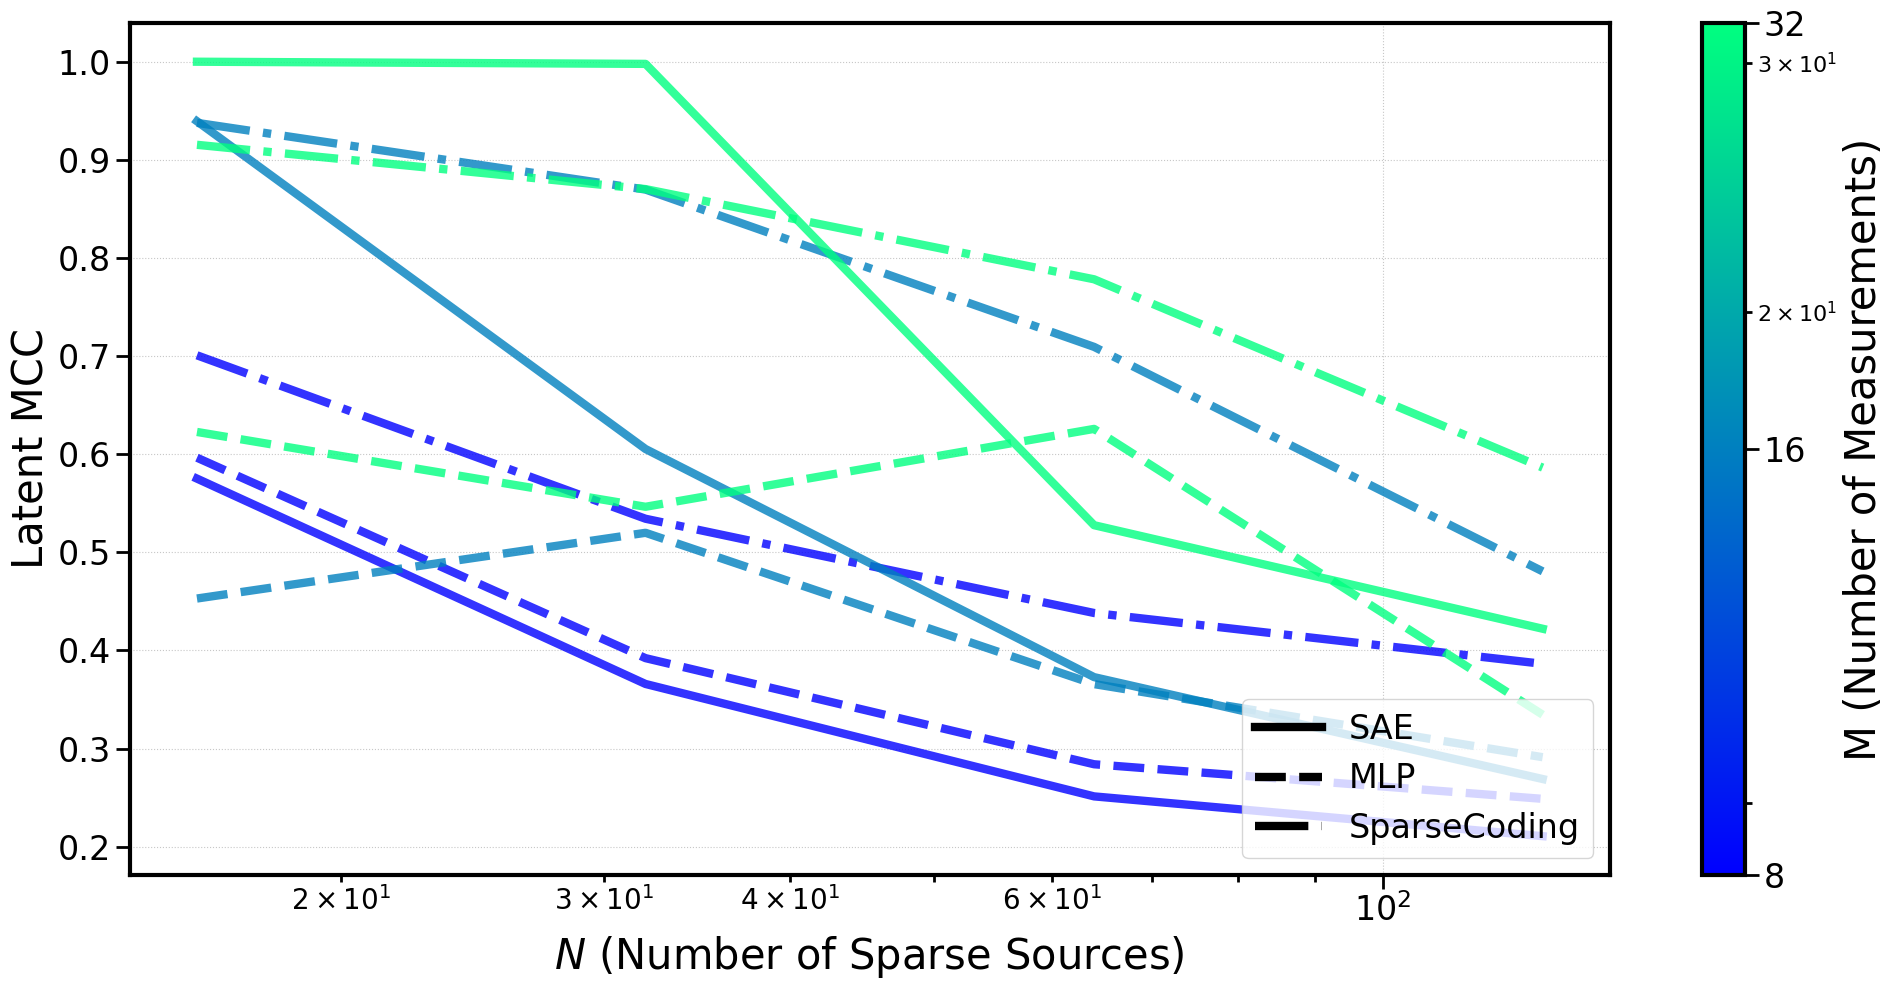

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import json

# Load results
with open('results/scaling_laws_results.json', 'r') as f:
    results = json.load(f)

# Parameters
base_font_size = 24
title_font_size = base_font_size * 1.5
label_font_size = base_font_size * 1.25
legend_font_size = base_font_size
tick_font_size = base_font_size
minor_tick_font_size = tick_font_size - 4

base_line_width = 6
data_line_width = base_line_width
box_line_width = 3
tick_width = 2

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Create colormap with log scale
cmap = plt.get_cmap('winter')
M_values = sorted([int(M) for M in results['SAE'].keys()])
norm = LogNorm(vmin=min(M_values), vmax=max(M_values))

# Plot data points and connecting lines
methods = ['SAE', 'MLP', 'SparseCoding']
linestyles = {'SAE': '-', 'MLP': '--', 'SparseCoding': '-.'}

for M in M_values:
    color = cmap(norm(M))
    for method in methods:
        N_values = [item[0] for item in results[method][str(M)]]
        mcc_values = [item[1] for item in results[method][str(M)]]
        
        # Plot lines
        ax.plot(N_values, mcc_values, color=color, linewidth=data_line_width, 
                linestyle=linestyles[method], alpha=0.8, label=f'{method} (M={M})')

# Customize the plot
ax.set_xscale('log')
ax.set_xlabel('$N$ (Number of Sparse Sources)', fontsize=label_font_size)
ax.set_ylabel('Latent MCC', fontsize=label_font_size)
ax.grid(True, linestyle=':', alpha=0.7)

# Set font size and width for tick labels and marks
ax.tick_params(axis='both', which='major', labelsize=tick_font_size, width=tick_width, length=10)
ax.tick_params(axis='both', which='minor', labelsize=minor_tick_font_size, width=tick_width, length=5)

# Make the bounding box thicker
for spine in ax.spines.values():
    spine.set_linewidth(box_line_width)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('M (Number of Measurements)', fontsize=label_font_size)

# Set font size and width for colorbar ticks
cbar.ax.tick_params(which='both', labelsize=minor_tick_font_size-4, width=tick_width, length=5)
cbar.ax.tick_params(which='major', length=10)

# Make colorbar border thicker
cbar.outline.set_linewidth(box_line_width)

# Adjust colorbar ticks to show actual M values
cbar.set_ticks(M_values)
cbar.set_ticklabels(M_values)

# Manually set font size for major ticks (M values)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(tick_font_size)

# Add legend for methods only
handles = [plt.Line2D([0], [0], color='black', linewidth=data_line_width, linestyle=linestyles[method]) for method in methods]
ax.legend(handles, methods, fontsize=legend_font_size, loc='lower right')

# Adjust layout and display
plt.tight_layout()

# Save figure
#plt.savefig('results/figures/scaling_laws_plot.pdf', dpi=300, bbox_inches='tight')

plt.show()

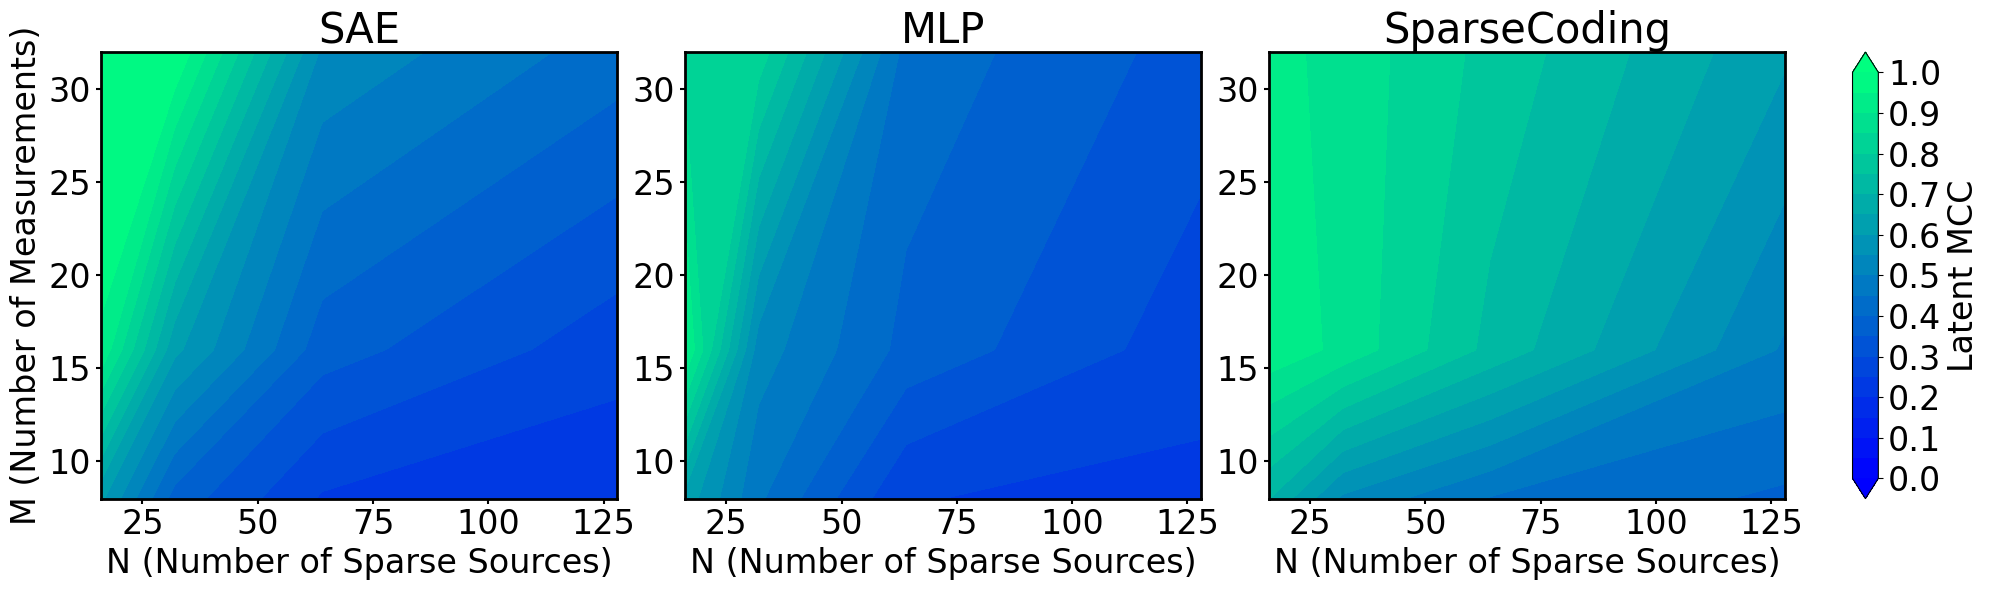

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import json

# Load results
K = 3
with open(f'results/scaling_laws_K_{K}.json', 'r') as f:
    results = json.load(f)

# Parameters
base_font_size = 24
title_font_size = base_font_size * 1.25
label_font_size = base_font_size
tick_font_size = base_font_size
box_line_width = 2
tick_width = 1.5

# Prepare data for contour plots
methods = ['SAE', 'MLP', 'SparseCoding']
N_values = sorted(list(set([item[0] for M in results['SAE'] for item in results['SAE'][M]])))
M_values = sorted([int(M) for M in results['SAE'].keys()])

X, Y = np.meshgrid(N_values, M_values)
Z = {method: [[0 for _ in range(X.shape[1])] for _ in range(X.shape[0])] for method in methods}

for i, M in enumerate(M_values):
    for j, N in enumerate(N_values):
        for method in methods:
            mcc_values = [item[1] for item in results[method][str(M)] if item[0] == N]
            if mcc_values:
                Z[method][i][j] = mcc_values[0]

# Set up the plot
fig = plt.figure(figsize=(20, 6))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 0.05])

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

# Create a single colorbar for all subplots
levels = np.linspace(0, 1, 21)  # 21 levels to get 20 intervals

for ax, method in zip(axes, methods):
    contour = ax.contourf(X, Y, Z[method], levels=levels, cmap='winter', extend='both')
    ax.set_title(method, fontsize=title_font_size)
    ax.set_xlabel('N (Number of Sparse Sources)', fontsize=label_font_size)
    if ax == axes[0]:
        ax.set_ylabel('M (Number of Measurements)', fontsize=label_font_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size, width=tick_width)
    ax.tick_params(axis='both', which='minor', width=tick_width)
    
    # Make the bounding box thicker
    for spine in ax.spines.values():
        spine.set_linewidth(box_line_width)

# Add a single colorbar for all subplots
cbar = fig.colorbar(contour, cax=cax)
cbar.set_label('Latent MCC', fontsize=label_font_size)
cbar.ax.tick_params(labelsize=tick_font_size)

# Set colorbar ticks and labels
cbar.set_ticks(np.linspace(0, 1, 11))  # 11 ticks from 0 to 1
cbar.set_ticklabels([f'{x:.1f}' for x in np.linspace(0, 1, 11)])  # Format to 2 decimal places

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'results/figures/scaling_laws_contour_plot_K_{K}.pdf', dpi=300, bbox_inches='tight')

plt.show()